<a href="https://colab.research.google.com/github/FabioMMaia/Trading-Predictions/blob/main/Modelo_BaseLine_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from string import punctuation
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import re

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor,export_text

import os, sys

sys.path.append(r'..\Git\Machine_Learning\functions')
import model_functions, EDA

C:\Users\fabio\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Estrategia usando Yahoo Finance

## Papeis no eixo vertical

In [ ]:
## Ganho % em relação a abertura 
def gain_var_period(data, var, periods):
    for period in periods:
        data['gain_'+var+'_'+str(period)+'D'] = data[var].shift(1)/data['Open'].shift(period)-1
    return data

def mean_var_period(data, var, periods):
    for period in periods:
        data['mean_'+var+'_'+str(period)+'D'] = data[var].rolling(period).mean()
    return data

def mean_ewm(data, var):
    data['ewm_'+var] = data[var].ewm(com=0.5).mean()
    return data

def trend_var_period(data, var, periods):
    for i, num_period in enumerate(periods):
        for j, den_period in enumerate(periods[i+1:]):
            data['trend_'+var+'_'+str(num_period)+'D'+'_'+str(den_period)+'D'] = (
                data['mean_'+var+'_'+str(num_period)+'D']/data['mean_'+var+'_'+str(den_period)+'D'])
    return data

def ratio(data, var_1, defasagem_1, var_2, defasagem_2):
    data[var_1+'_'+str(defasagem_1)+'_'+var_2+'_'+str(defasagem_2)] = data[var_1].shift(defasagem_1)/data[var_2].shift(defasagem_2)-1
    return data 

def candles(data, defasagem):
    data['cauda_inf_D_'+str(defasagem)] = (data[['Open', 'Close']]
                                           .shift(defasagem).min(axis=1) - data[['Low']]
                                           .shift(defasagem).min(axis=1))/data['Open']
    
    data['cauda_sup_D_'+str(defasagem)] = (data[['High']]
                                           .shift(defasagem)
                                           .min(axis=1) - data[['Open', 'Close']]
                                           .shift(defasagem).max(axis=1))/data['Open']
    
    data['corpo_D_'+str(defasagem)] = (data[['Open', 'Close']]
                                       .shift(defasagem).max(axis=1) - data[['Open', 'Close']]
                                       .shift(defasagem).max(axis=1))/data['Open']
    
    return data

In [ ]:
def pipeline(ticker, start_date, end_date):
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    data_ticker['ticker'] = ticker
    
    data_ticker = (data_ticker
                   .reset_index()
                   .rename(columns={'Date':'data_chave'})
                   .set_index('data_chave')
                 )
    
    
    print('### Carregando ticker - ',ticker)
    print('Shape antes de dropar na:', data_ticker.shape)
    
    if (data_ticker.isna().any(axis=1).sum()>0):
        data_ticker[data_ticker.isna().any(axis=1)].to_excel('evaluate_na_' + ticker + '.xlsx')  
    
    data_ticker.dropna(inplace=True)
    
    print('Shape após dropar na:', data_ticker.shape)

    
#     ADICIONA FFILL
#     data_ticker.ffill(axis=0, inplace=True, limit=3)

    # Ganhos recentes (lags)
    data_ticker = gain_var_period(data_ticker, 'Close', [1,2,3,4,5])
    data_ticker = gain_var_period(data_ticker, 'High', [1,2,3,4,5])

    # Médias móveis
    data_ticker['Close_1D'] = data_ticker['Close'].shift(1)
    data_ticker = mean_var_period(data_ticker, 'Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = mean_var_period(data_ticker, 'gain_Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = mean_var_period(data_ticker, 'gain_High_1D', [2,3,4,5,15,30,60,90,180])
    
    # Médias Exponenciais
    data_ticker = mean_ewm(data_ticker, 'Close_1D')
    data_ticker = mean_ewm(data_ticker, 'gain_Close_1D')
    data_ticker = mean_ewm(data_ticker, 'gain_High_1D')

    # # Tendências
    data_ticker = trend_var_period(data_ticker, 'Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = trend_var_period(data_ticker, 'gain_Close_1D', [2,3,4,5,15,30,60,90,180])
    data_ticker = trend_var_period(data_ticker, 'gain_High_1D', [2,3,4,5,15,30,60,90,180])

    # # Razões diárias
    for i in range(2,5):
        data_ticker = ratio(data_ticker, 'Low', 1, 'Low', i)
        data_ticker = ratio(data_ticker, 'High', 1, 'High', i)
        data_ticker = ratio(data_ticker, 'Low', 1, 'High', i)
        data_ticker = ratio(data_ticker, 'High', 1, 'Low', i)

    # # Candles
    data_ticker = candles(data_ticker,1)
    data_ticker = candles(data_ticker,2)
    data_ticker = candles(data_ticker,3)
    data_ticker = candles(data_ticker,4)
    data_ticker = candles(data_ticker,5)

    return data_ticker

In [ ]:
ticker = ['^BVSP']

start_date = '2015-01-01'
end_date= '2021-06-01'

df_bovespa = yf.download(ticker, start=start_date, end=end_date)

df_bovespa.head()

[*********************100%***********************]  1 of 1 completed


Open     High      Low    Close  Adj Close   Volume
Date                                                              
2015-01-02  50005.0  50005.0  48345.0  48512.0    48512.0  2882100
2015-01-05  48512.0  48512.0  47264.0  47517.0    47517.0  3866100
2015-01-06  47517.0  48061.0  47338.0  48001.0    48001.0  4559300
2015-01-07  48006.0  49882.0  48006.0  49463.0    49463.0  4408800
2015-01-08  49463.0  50261.0  49017.0  49943.0    49943.0  3621900

In [ ]:
EDA.dataframe_description(df_bovespa)

Tipo  Total de Missing  % de Missing   count          mean  \
Open       float64                 0           0.0  1580.0  7.799924e+04   
High       float64                 0           0.0  1580.0  7.878664e+04   
Low        float64                 0           0.0  1580.0  7.725371e+04   
Close      float64                 0           0.0  1580.0  7.804972e+04   
Adj Close  float64                 0           0.0  1580.0  7.804972e+04   
Volume       int64                 0           0.0  1580.0  5.032356e+06   

                    std      min         25%        50%         75%  \
Open       2.324405e+04  37501.0    57235.75    76368.0    97780.75   
High       2.341104e+04  38031.0    57915.00    76990.5    98360.75   
Low        2.308756e+04  37046.0    56826.75    75602.0    96944.25   
Close      2.327040e+04  37497.0    57253.50    76402.0    97813.50   
Adj Close  2.327040e+04  37497.0    57253.50    76402.0    97813.50   
Volume     2.880663e+06      0.0  3228150.00  3995350.0  5672100.00   

                  max  
Open         125561.0  
High         126216.0  
Low          125540.0  
Close        126216.0  
Adj Close    126216.0  
Volume     21768700.0

In [ ]:
def add_rolling_mean(data, var, periods):
    for period in periods:
        data['X_mean_'+var+'_'+str(period)+'D'] = data[var].rolling(period).mean()
    return data

# Médias móveis
def medias_moveis(df):
    data_ticker = df.copy()
    data_ticker['Close_1D'] = data_ticker['Close'].shift(1)
    data_ticker = add_rolling_mean(data_ticker, 'Close_1D', [2,3,4,5,15,30,60,90,180])
#     data_ticker = mean_var_period(data_ticker, 'gain_Close_1D', [2,3,4,5,15,30,60,90,180])
#     data_ticker = mean_var_period(data_ticker, 'gain_High_1D', [2,3,4,5,15,30,60,90,180])
    return data_ticker

df_bovespa = medias_moveis(df_bovespa)

In [ ]:
df_bovespa.dropna(inplace=True)

In [ ]:
df_bovespa.head()

In [ ]:
# exemplo para o dia 2020-09*24 = (97294.0 + 95735.0)/2
(97294.0 + 95735.0)/2

In [ ]:
EDA.dataframe_description(df_bovespa)

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(20,8))

df_bovespa.filter(like='mean_Close').plot(ax=axes)

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(20,8))

# filtro apenas o ultimo ano
df_bovespa.iloc[-360:,:].filter(like='mean_Close').plot(ax=axes)

In [ ]:
# def target_close(df, n_per, alpha):
#     data_ticker = df.copy()
#     data_ticker['valor_futuro_'+str(n_per)+'D']= data_ticker['Close'].shift(-n_per)
#     data_ticker['%_valorizacao_'+ str(n_per) +'D'] = (data_ticker['Close'].shift(-n_per)-data_ticker['Close'])/data_ticker['Close']
#     data_ticker['valorizacao_' + str(alpha) + '%_target_'+ str(n_per) +'D'] = (data_ticker['%_valorizacao_'+ str(n_per) +'D']>=alpha).astype(int)
#     return data_ticker

# df_bovespa = target_close(df_bovespa,5,0.02)

# df_bovespa.head(10)

In [ ]:
# df_bovespa.filter(like='target').value_counts()

In [ ]:
def target_High_maior_Open(row, delta):
    
    if row['High'] > (1+delta)*row['Open']:
        target = 1
    else:
        target = 0
    
    return target

df_bovespa['target'] = df_bovespa.apply(target_High_maior_Open, delta=0.01,axis=1)

In [ ]:
X_df = df_bovespa.filter(like='X_')
y_df = df_bovespa.filter(like='target')

In [ ]:
# y_df.isna().sum()

In [ ]:
X_train.index.min()

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_df,
                                        y_df,
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)


print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier= LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

classifier= LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
y_train['p_target']= classifier.predict_proba(X_train)[:,1]
y_test['p_target'] = classifier.predict_proba(X_test)[:,1]

In [ ]:
X_test

In [ ]:
# TO DO

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,5))
sns.histplot(data=y_test.query("target == 1")['p_target'], label = 'target = 1', color = 'b', kde=True, bins=30)
sns.histplot(data=y_test.query("target == 0")['p_target'], label = 'target = 0', color = 'r', kde=True, bins=30)

plt.axvline(x=y_test.query("target == 1")['p_target'].mean(), color = 'b');
plt.axvline(x=y_test.query("target == 0")['p_target'].mean(), color = 'r');

In [ ]:
# TREND VARIAVEIS
# AJUSTAR FUNCAO
# MODELO RESTRITITIVOS

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifier= DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.05)
classifier.fit(X_train, y_train[['target']])
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train[['target']], display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test[['target']], display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier= GradientBoostingClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
def plot_feature_importance(model, n_top=20):
    
    df_feature_importance = pd.DataFrame({'features': X_train.columns.to_list(),
                                          'feature importance':model.feature_importances_})
    df_feature_importance.set_index('features', inplace=True)
    df_feature_importance.sort_values(by = 'feature importance', ascending=True, inplace=True)
    df_feature_importance.tail(n_top).plot(kind='barh')
    plt.legend(loc='lower right')
    plt.show()

    return df_feature_importance

plot_feature_importance(classifier, n_top=20)

In [ ]:
import numpy as np
X_df['randNumCol'] = np.random.randint(1, 100, X_df.shape[0])



X_train, X_test, y_train, y_test= train_test_split(X_df,
                                        y_df,
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)


print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

classifier= GradientBoostingClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
plot_feature_importance(classifier, n_top=20)

# Pipe Full Original

In [ ]:
# tickers = ['ITUB3.SA', 'VALE3.SA', 'PETR4.SA', 'PETR3.SA', 'ABEV3.SA', 'BBAS3.SA', 'ITSA4.SA']
# tickers = ['ITSA4.SA', 'ITUB4.SA', 'BBDC4.SA', 'BBAS3.SA', 'BBDC3.SA','ITUB3.SA', 'USDBRL=X']
# tickers = ['^BVSP','ITSA4.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA','ITUB3.SA',
#            'VALE3.SA', 'PETR4.SA', 'PETR3.SA', 'ABEV3.SA']
tickers = ['^BVSP','ITUB4.SA']

start_date = "2010-01-01"
end_date = "2020-11-01"

for i, ticker in enumerate(tickers):
    print(i)
    if (i==0):
        data_acao = pipeline(ticker, start_date, end_date)
        data_acao = data_acao.add_prefix(ticker+"_")
    else:
        aux = pipeline(ticker, start_date, end_date)
        aux = aux.add_prefix(ticker+"_")
        data_acao = pd.merge(data_acao, aux, left_index=True, right_index=True, how='outer')

    print('tabela merge dimensoes:', data_acao.shape)
    
# data_aco = data_acoes.sort_index()

data_acao.tail(10)

In [ ]:
pd.set_option('display.max_rows', None)

EDA.dataframe_description(data_acao)

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
import missingno

missingno.matrix(data_acao);
# missingno.matrix(data_acao.sample(250))

In [ ]:
def target_close(df, n_per, alpha, ticker=''):
    if (ticker!=''):
        ticker = ticker + '_'
    
    data_ticker = df.copy()
    data_ticker['valor_futuro_'+str(n_per)+'D']= data_ticker[ticker+'Close'].shift(-n_per)
    data_ticker['%_valorizacao_'+ str(n_per) +'D'] = ((data_ticker[ticker+'Close'].shift(-n_per)-data_ticker[ticker+'Close'])/
                                                      data_ticker[ticker+'Close'])
    data_ticker['valorizacao_' + str(alpha) + '%_target_'+ str(n_per) +'D'] = (data_ticker['%_valorizacao_'+ str(n_per) +'D']>=alpha).astype(int)
    data_ticker.drop(columns = ['valor_futuro_'+str(n_per)+'D', '%_valorizacao_'+ str(n_per) +'D'], inplace=True)
    
    return data_ticker

data_acao = target_close(data_acao,5,0.02,'ITUB4.SA')

data_acao.head(10)

In [ ]:
data_acao.filter(like='target').value_counts()

In [ ]:
data_acao.replace([np.inf, -np.inf], np.nan, inplace=True)
data_acao.dropna(inplace=True)

In [ ]:
def create_exp_vars(data_acao):
    exp_vars=[]

    for c_ in data_acao.columns:
        blacklist = ['Open','High','Low','Close','Adj Close','Volume','Open_D1',
                 'gain_high','gain_close','loss_low','gain_overnight','target','p_target',
                'ticker']
    #     print(c_)
        if not ('target' in c_):
            if c_.split('_')[1] not in blacklist :
                exp_vars.append(c_)
                
    return exp_vars

vars_keep = create_exp_vars(data_acao)

X_df = data_acao[vars_keep].add_prefix('X_')
y_df = data_acao.filter(like='target')

In [ ]:
X_df.head()

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_df,
                                        y_df,
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)


print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))

In [ ]:
classifier= GradientBoostingClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
plot_feature_importance(classifier, n_top=20);

In [ ]:
# Com Grid Search

from sklearn.model_selection import GridSearchCV

def grid_search(basemodel, param_grid, X,y,nfolds):
    
    #use gridsearch to test all values
    gridsearch = GridSearchCV(basemodel, 
                              param_grid, 
                              cv=nfolds,
                              scoring=['roc_auc', 'accuracy', 'f1', 'recall'],
                              return_train_score=True,
                              refit= 'roc_auc',
                             verbose=3)
    
    #fit model to data
    gridsearch.fit(X, y.values.ravel())
    
    return gridsearch

param_grid = {}
param_grid['n_estimators'] = [10, 50, 100, 500]
param_grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]
param_grid['subsample'] = [0.5, 0.7, 1.0]
param_grid['min_samples_leaf'] = [0.05, 0.1,0.2,1]
param_grid['max_depth'] = [3, 7, 9, 15]
param_grid['random_state'] = [42]

gs = grid_search(GradientBoostingClassifier(random_state=42), param_grid, X_train ,y_train,5)

classifier = gs.best_estimator_

classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)

y_pred_test = classifier.predict(X_test)

plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
pd.DataFrame(gs.cv_results_)

In [ ]:
# EDA.print_correlation_matrix(data_acao)

In [ ]:
# APLICA LOG DO RETORNO - CONSIDERANDO TICKER

def target_log_retorno(row, ticker):
    log_retorno =  np.log([ticker+'_Adj Close']/row[ticker+'_Adj Close'].shift(1))
    return log_retorno

def target_High_maior_Open(row, delta, ticker):
    if row[ticker+'_High'] > (1+delta)*row[ticker+'_Open']:
        target = 1
    else:
        target = 0
    return target

def trata_na(data_acao):
    print('dim antes de dropar os na:', data_acao.shape)
    data_acao.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_acao.dropna(inplace=True)
    data_acao[pd.isnull(data_acao).any(axis=1)]
    print('dim após dropar os na:', data_acao.shape)
    return data_acao

def create_exp_vars(data_acao):
    exp_vars=[]

    for c_ in data_acao.columns:
        blacklist = ['Open','High','Low','Close','Adj Close','Volume','Open_D1',
                 'gain_high','gain_close','loss_low','gain_overnight','target','p_target',
                'ticker']
    #     print(c_)
        if c_  != 'target':
            if c_.split('_')[1] not in blacklist :
                exp_vars.append(c_)
                
    return exp_vars

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def pipe_model(aux_bvsp, exp_vars, tts_size=0.2):
    

    data_train,data_test = train_test_split(aux_bvsp,
                                                 test_size=tts_size,
                                                 random_state=2020,
                                                 shuffle=False)
    
    X_train = data_train[exp_vars]
    y_train = data_train['target']

    X_test = data_test[exp_vars]
    y_test = data_test['target']
    
#     mdl,cv_r = train(X_train, y_train,method)

    regressor = DecisionTreeRegressor(random_state=42, min_samples_leaf=0.05)
    
    regressor.fit(X_train, y_train)

    return regressor, X_train, y_train, X_test, y_test


In [ ]:
def class_metrics_resume(ticker, clf, X_train, y_train, y_score_train, y_pred_train, X_test, y_test, y_score_test, y_pred_test):
    resume={}
    resume['ticker']=[ticker]
    resume['AUC treino']=[roc_auc_score(y_train, y_score_train)]
    resume['acuracia treino']=[clf.score(X_train, y_train)]
    resume['precision treino']=[precision_score(y_train, y_pred_train)]
    resume['recall treino']=[recall_score(y_train, y_pred_train)]
    resume['f1 treino']=[f1_score(y_train, y_pred_train)]
    resume['AUC teste']=[roc_auc_score(y_test, y_score_test)]
    resume['acuracia teste']=[clf.score(X_test, y_test)]
    resume['precision teste']=[precision_score(y_test, y_pred_test)]
    resume['recall teste']=[recall_score(y_test, y_pred_test)]
#     colocar o gini
    resume['f1 teste']=[f1_score(y_test, y_pred_test)]
    
    return pd.DataFrame(resume)

def plt_cm(cm,labels):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [ ]:
list(data_acao.columns)

In [ ]:
# TESTANDO REGRESSÃO PARA UM DOS TICKERS

t_ = 'ITUB4.SA'
print('####TARGET:', t_)
data_model = data_acao.copy()

# data_model['target'] =  np.log(data_model[t_+'_Adj Close']/data_model[t_+'_Adj Close'].shift(1))
# retorno
data_model['target'] = data_model[t_+'_Adj Close']/(data_model[t_+'_Adj Close'] - data_model[t_+'_Adj Close'].shift(1))

# variaveis reposta média movel semana/ semana anterior  ==> indentificar semana  

data_model = trata_na(data_model)
exp_vars = create_exp_vars(data_model)

# feature_importance(data_model, exp_vars)
reg, X_train, y_train, X_test, y_test = pipe_model(data_model,exp_vars,tts_size=0.25)

In [ ]:
# BASELINE - MÉDIAS MÓVEIS

# DEFINIR TARGET - DIA/SEMANA/MES  ===> QUAL VALORIZAÇÃO? (OVER/EVER - ALGUM MOMENTO OU NO FINAL DO PERIODO)

# BACKTEST - 




# Usando lib TA

In [ ]:
ticker = ['^BVSP']

start_date = '2015-01-01'
end_date= '2021-06-01'

df_bovespa = yf.download(ticker, start=start_date, end=end_date)

df_bovespa.head()

[*********************100%***********************]  1 of 1 completed


Open     High      Low    Close  Adj Close   Volume
Date                                                              
2015-01-02  50005.0  50005.0  48345.0  48512.0    48512.0  2882100
2015-01-05  48512.0  48512.0  47264.0  47517.0    47517.0  3866100
2015-01-06  47517.0  48061.0  47338.0  48001.0    48001.0  4559300
2015-01-07  48006.0  49882.0  48006.0  49463.0    49463.0  4408800
2015-01-08  49463.0  50261.0  49017.0  49943.0    49943.0  3621900

In [ ]:
from ta import add_all_ta_features

In [ ]:
df_ta = add_all_ta_features(
    df_bovespa, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=False)

C:\Users\fabio\Anaconda\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\fabio\Anaconda\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [ ]:
df_ta.head()

Open     High      Low    Close  Adj Close   Volume  \
Date                                                                 
2015-01-02  50005.0  50005.0  48345.0  48512.0    48512.0  2882100   
2015-01-05  48512.0  48512.0  47264.0  47517.0    47517.0  3866100   
2015-01-06  47517.0  48061.0  47338.0  48001.0    48001.0  4559300   
2015-01-07  48006.0  49882.0  48006.0  49463.0    49463.0  4408800   
2015-01-08  49463.0  50261.0  49017.0  49943.0    49943.0  3621900   

              volume_adi  volume_obv  volume_cmf  volume_fi  volume_mfi  \
Date                                                                      
2015-01-02 -2.302208e+06     2882100         NaN        NaN         NaN   
2015-01-05 -4.600802e+06     -984000         NaN        NaN         NaN   
2015-01-06 -7.982326e+05     3575300         NaN        NaN         NaN   
2015-01-07  1.641178e+06     7984100         NaN        NaN         NaN   
2015-01-08  3.411367e+06    11606000         NaN        NaN         NaN   

               volume_em  volume_sma_em    volume_vpt   volume_nvi  \
Date                                                                 
2015-01-02           NaN            NaN -1.087748e+06  1000.000000   
2015-01-05 -4.154512e+07            NaN -1.170019e+06  1000.000000   
2015-01-06 -2.989176e+06            NaN -3.285497e+04  1000.000000   
2015-01-07  5.295504e+07            NaN  1.807221e+05  1030.457699   
2015-01-08  2.387090e+07            NaN  1.694296e+05  1040.457490   

            volume_vwap  volatility_atr  volatility_bbm  volatility_bbh  \
Date                                                                      
2015-01-02          NaN             0.0             NaN             NaN   
2015-01-05          NaN             0.0             NaN             NaN   
2015-01-06          NaN             0.0             NaN             NaN   
2015-01-07          NaN             0.0             NaN             NaN   
2015-01-08          NaN             0.0             NaN             NaN   

            volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
Date                                                                          
2015-01-02             NaN             NaN             NaN              0.0   
2015-01-05             NaN             NaN             NaN              0.0   
2015-01-06             NaN             NaN             NaN              0.0   
2015-01-07             NaN             NaN             NaN              0.0   
2015-01-08             NaN             NaN             NaN              0.0   

            volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
Date                                                                          
2015-01-02              0.0             NaN    50614.000000    47294.000000   
2015-01-05              0.0             NaN    49813.166667    46905.166667   
2015-01-06              0.0             NaN    49383.111111    46962.444444   
2015-01-07              0.0             NaN    49785.583333    47032.083333   
2015-01-08              0.0             NaN    50025.333333    47324.933333   

            volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
Date                                                                           
2015-01-02             NaN        0.366867              0.0              0.0   
2015-01-05             NaN        0.210397              0.0              0.0   
2015-01-06             NaN        0.429037              0.0              0.0   
2015-01-07             NaN        0.882846              0.0              0.0   
2015-01-08             NaN        0.969511              0.0              0.0   

            volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
Date                                                                         
2015-01-02             NaN             NaN             NaN             NaN   
2015-01-05             NaN             NaN             NaN             NaN   


In [ ]:
EDA.dataframe_description(df_ta)

Tipo  Total de Missing  % de Missing   count  \
Open                       float64                 0      0.000000  1580.0   
High                       float64                 0      0.000000  1580.0   
Low                        float64                 0      0.000000  1580.0   
Close                      float64                 0      0.000000  1580.0   
Adj Close                  float64                 0      0.000000  1580.0   
Volume                       int64                 0      0.000000  1580.0   
volume_adi                 float64                 0      0.000000  1580.0   
volume_obv                   int64                 0      0.000000  1580.0   
volume_cmf                 float64                19      0.012025  1561.0   
volume_fi                  float64                13      0.008228  1567.0   
volume_mfi                 float64                13      0.008228  1567.0   
volume_em                  float64                 2      0.001266  1578.0   
volume_sma_em              float64               241      0.152532  1339.0   
volume_vpt                 float64                 0      0.000000  1580.0   
volume_nvi                 float64                 0      0.000000  1580.0   
volume_vwap                float64                13      0.008228  1567.0   
volatility_atr             float64                 0      0.000000  1580.0   
volatility_bbm             float64                19      0.012025  1561.0   
volatility_bbh             float64                19      0.012025  1561.0   
volatility_bbl             float64                19      0.012025  1561.0   
volatility_bbw             float64                19      0.012025  1561.0   
volatility_bbp             float64                19      0.012025  1561.0   
volatility_bbhi            float64                 0      0.000000  1580.0   
volatility_bbli            float64                 0      0.000000  1580.0   
volatility_kcc             float64                 9      0.005696  1571.0   
volatility_kch             float64                 0      0.000000  1580.0   
volatility_kcl             float64                 0      0.000000  1580.0   
volatility_kcw             float64                 9      0.005696  1571.0   
volatility_kcp             float64                 0      0.000000  1580.0   
volatility_kchi            float64                 0      0.000000  1580.0   
volatility_kcli            float64                 0      0.000000  1580.0   
volatility_dcl             float64                19      0.012025  1561.0   
volatility_dch             float64                19      0.012025  1561.0   
volatility_dcm             float64                19      0.012025  1561.0   
volatility_dcw             float64                19      0.012025  1561.0   
volatility_dcp             float64                19      0.012025  1561.0   
volatility_ui              float64                13      0.008228  1567.0   
trend_macd                 float64                25      0.015823  1555.0   
trend_macd_signal          float64                33      0.020886  1547.0   
trend_macd_diff            float64                33      0.020886  1547.0   
trend_sma_fast             float64                11      0.006962  1569.0   
trend_sma_slow             float64                25      0.015823  1555.0   
trend_ema_fast             float64                11      0.006962  1569.0   
trend_ema_slow             float64                25      0.015823  1555.0   
trend_adx                  float64                 0      0.000000  1580.0   
trend_adx_pos              float64                 0      0.000000  1580.0   
trend_adx_neg              float64                 0      0.000000  1580.0   
trend_vortex_ind_pos       float64                14      0.008861  1566.0   
trend_vortex_ind_neg       float64                14      0.008861  1566.0   
trend_vortex_ind_diff      float64                14      0.008861  1566.0   
trend_trix                 float64                43

In [ ]:
EDA.dataframe_description(df_ta).sort_values(by='% de Missing', ascending=False)

Tipo  Total de Missing  % de Missing   count  \
trend_psar_down            float64               902      0.570886   678.0   
trend_psar_up              float64               680      0.430380   900.0   
volume_sma_em              float64               241      0.152532  1339.0   
trend_stc                  float64                71      0.044937  1509.0   
trend_trix                 float64                43      0.027215  1537.0   
trend_mass_index           float64                40      0.025316  1540.0   
momentum_tsi               float64                37      0.023418  1543.0   
momentum_ppo_hist          float64                33      0.020886  1547.0   
momentum_ppo_signal        float64                33      0.020886  1547.0   
trend_macd_signal          float64                33      0.020886  1547.0   
trend_macd_diff            float64                33      0.020886  1547.0   
momentum_ao                float64                33      0.020886  1547.0   
momentum_stoch_rsi_d       float64                30      0.018987  1550.0   
momentum_stoch_rsi_k       float64                28      0.017722  1552.0   
momentum_uo                float64                28      0.017722  1552.0   
momentum_stoch_rsi         float64                26      0.016456  1554.0   
trend_ema_slow             float64                25      0.015823  1555.0   
trend_sma_slow             float64                25      0.015823  1555.0   
trend_ichimoku_base        float64                25      0.015823  1555.0   
trend_macd                 float64                25      0.015823  1555.0   
trend_ichimoku_a           float64                25      0.015823  1555.0   
trend_visual_ichimoku_a    float64                25      0.015823  1555.0   
momentum_ppo               float64                25      0.015823  1555.0   
trend_aroon_up             float64                24      0.015190  1556.0   
trend_aroon_down           float64                24      0.015190  1556.0   
trend_aroon_ind            float64                24      0.015190  1556.0   
volatility_dch             float64                19      0.012025  1561.0   
trend_cci                  float64                19      0.012025  1561.0   
trend_dpo                  float64                19      0.012025  1561.0   
volatility_dcp             float64                19      0.012025  1561.0   
volatility_dcw             float64                19      0.012025  1561.0   
volatility_dcm             float64                19      0.012025  1561.0   
volatility_dcl             float64                19      0.012025  1561.0   
volatility_bbm             float64                19      0.012025  1561.0   
volume_cmf                 float64                19      0.012025  1561.0   
volatility_bbp             float64                19      0.012025  1561.0   
volatility_bbw             float64                19      0.012025  1561.0   
volatility_bbl             float64                19      0.012025  1561.0   
volatility_bbh             float64                19      0.012025  1561.0   
momentum_stoch_signal      float64                15      0.009494  1565.0   
trend_kst_diff             float64                14      0.008861  1566.0   
trend_kst_sig              float64                14      0.008861  1566.0   
trend_kst                  float64                14      0.008861  1566.0   
trend_vortex_ind_neg       float64                14      0.008861  1566.0   
trend_vortex_ind_pos       float64                14      0.008861  1566.0   
trend_vortex_ind_diff      float64                14      0.008861  1566.0   
momentum_stoch             float64                13      0.008228  1567.0   
volatility_ui              float64                13      0.008228  1567.0   
volume_fi                  float64                13      0.008228  1567.0   
volume_mfi                 float64                13      0.008228  1567.0   
momentum_wr                float64                13

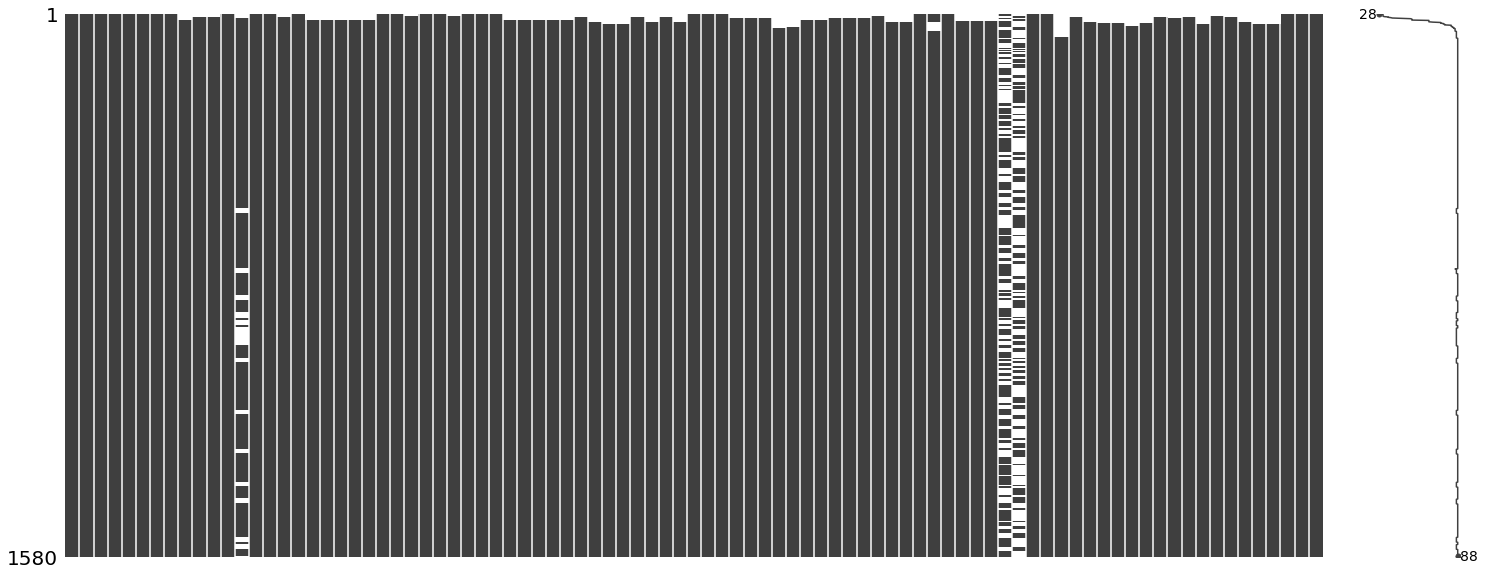

In [ ]:
import missingno

missingno.matrix(df_ta);

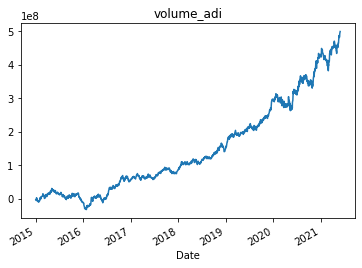

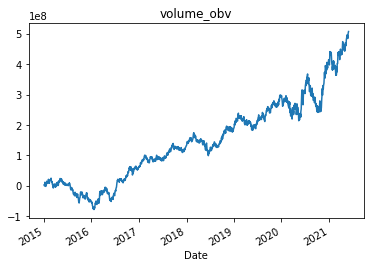

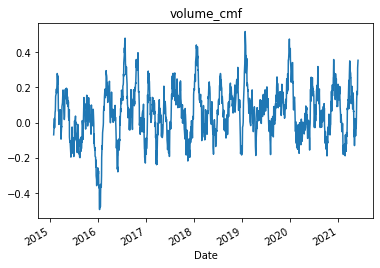

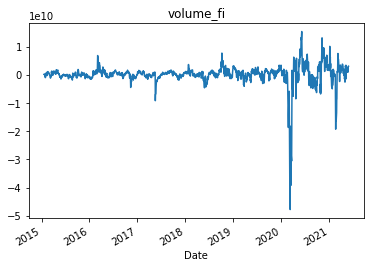

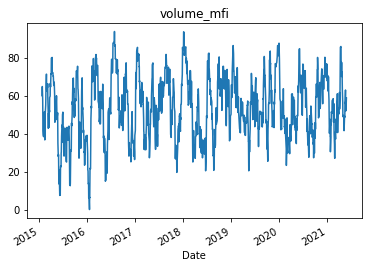

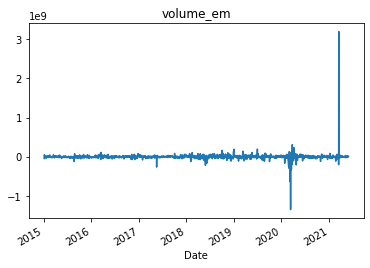

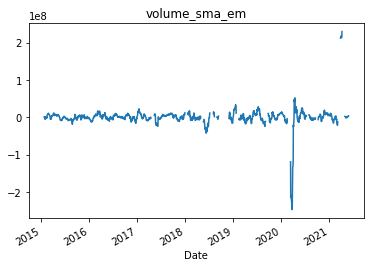

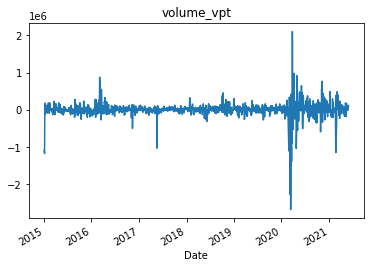

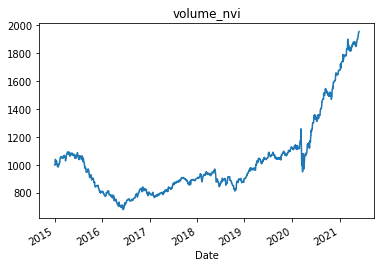

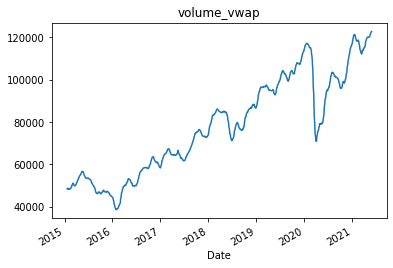

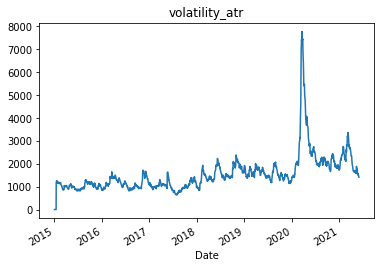

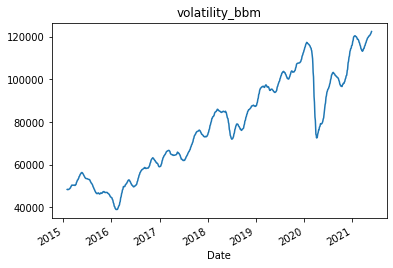

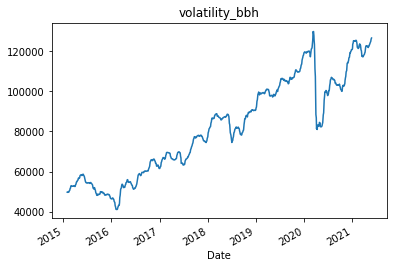

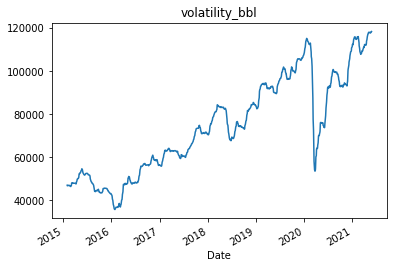

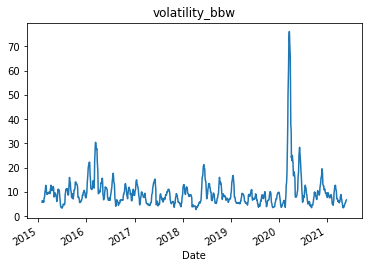

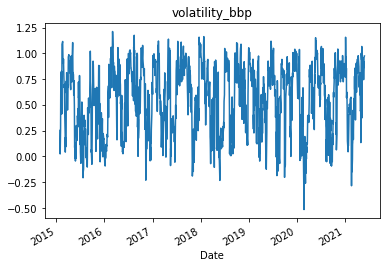

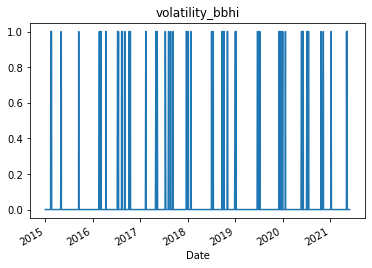

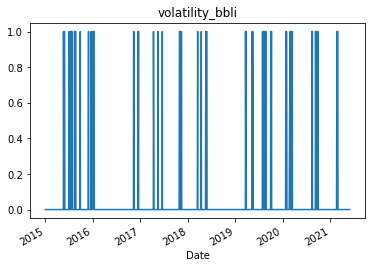

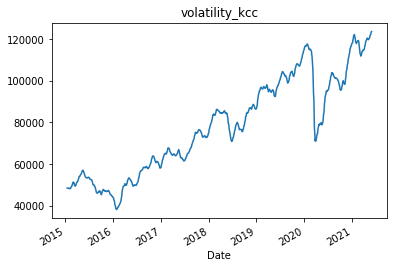

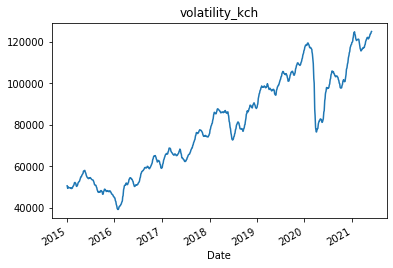

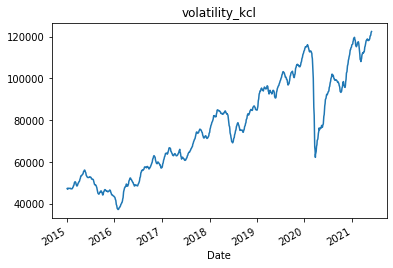

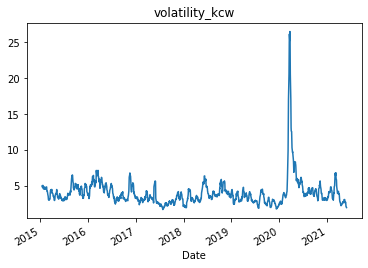

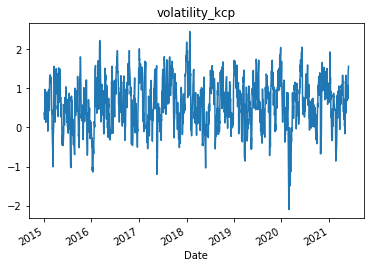

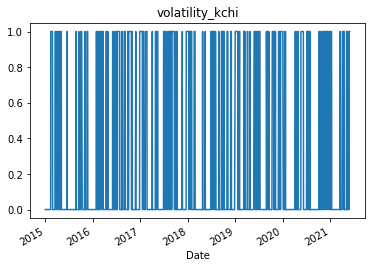

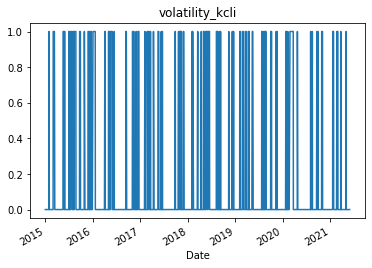

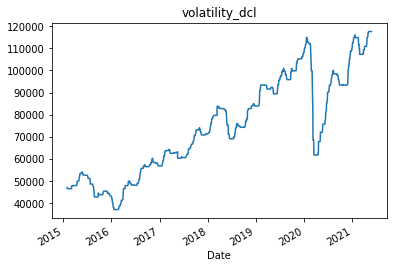

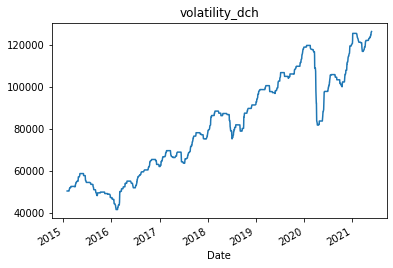

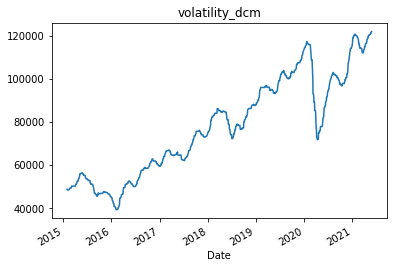

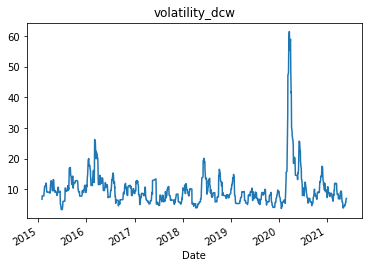

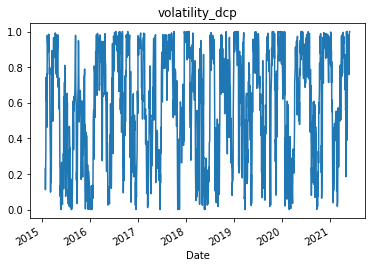

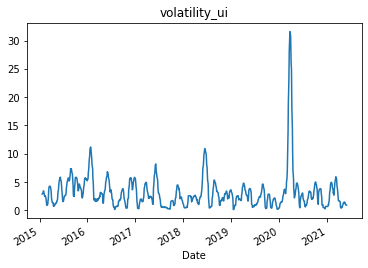

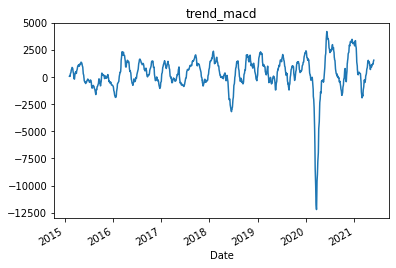

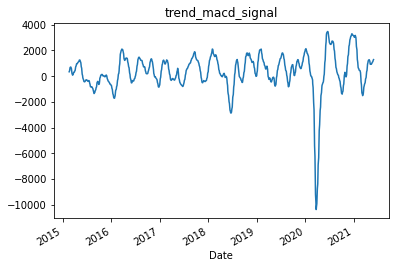

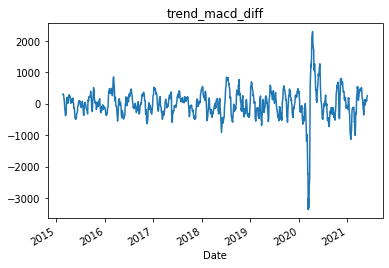

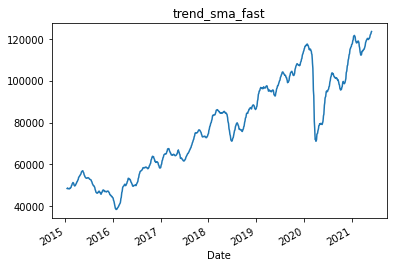

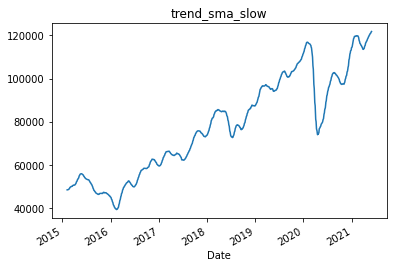

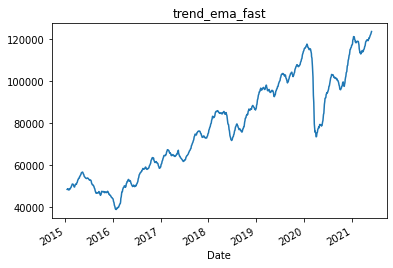

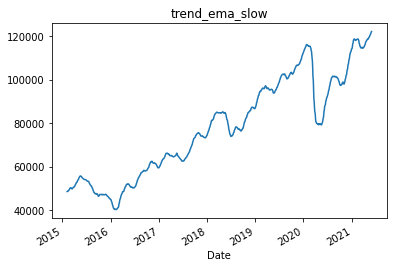

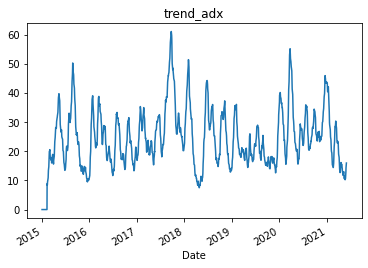

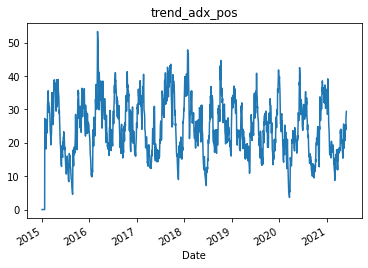

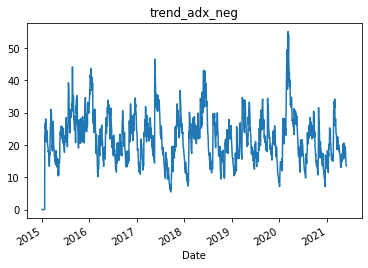

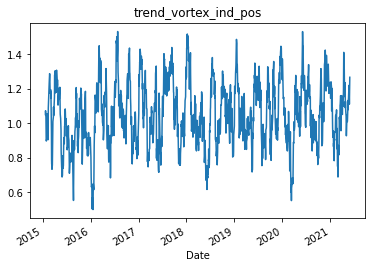

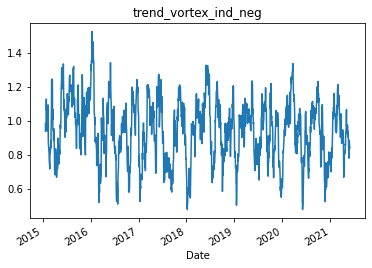

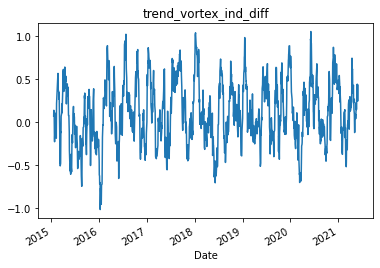

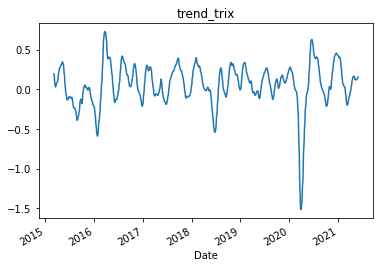

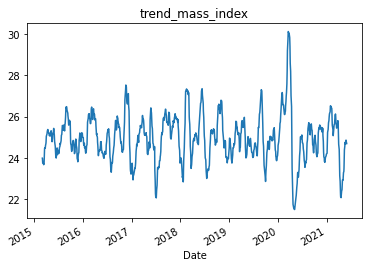

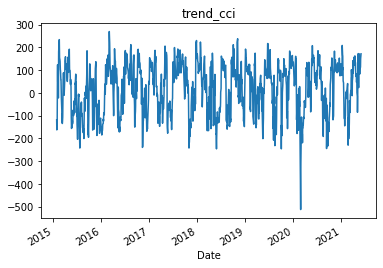

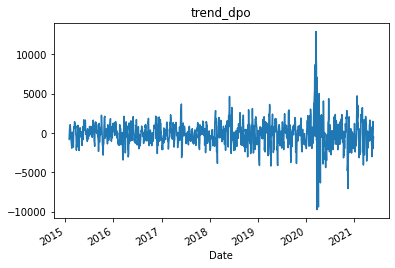

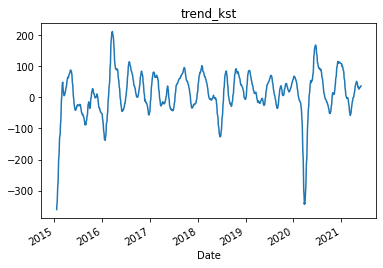

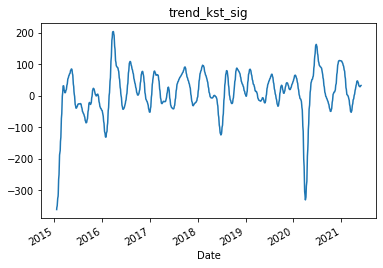

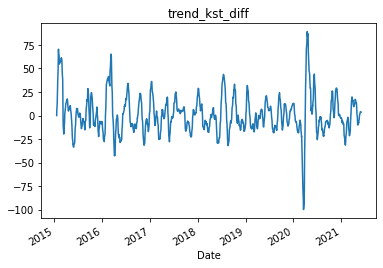

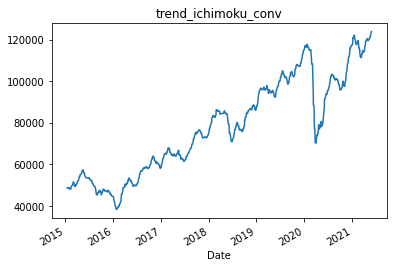

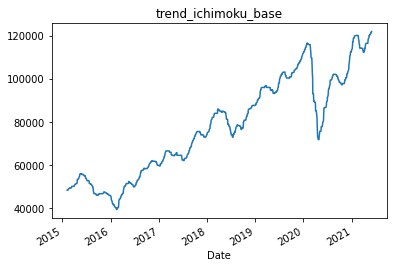

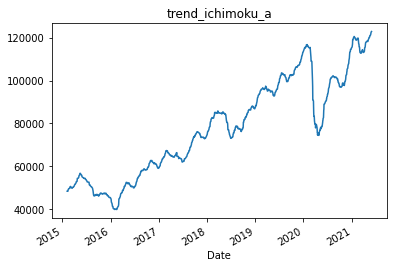

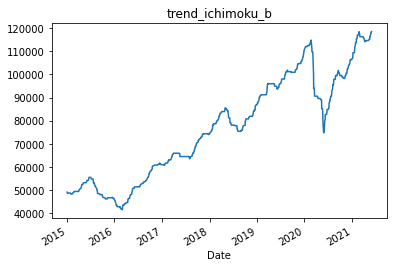

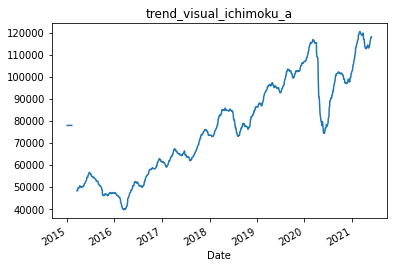

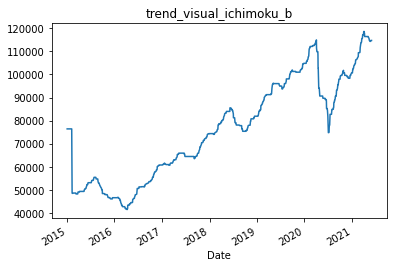

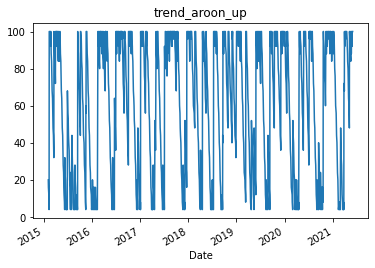

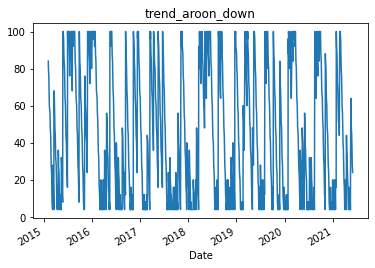

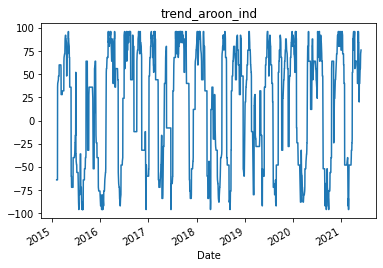

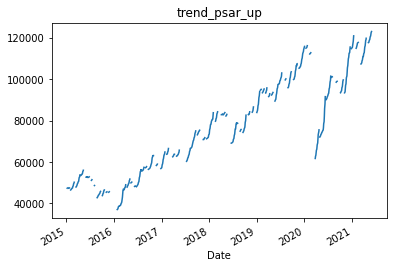

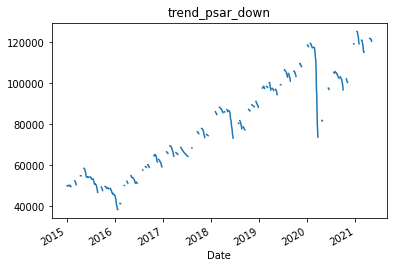

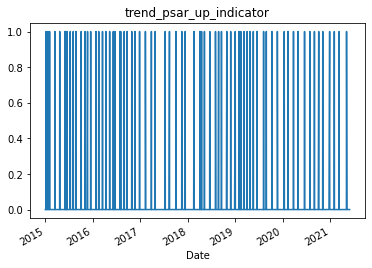

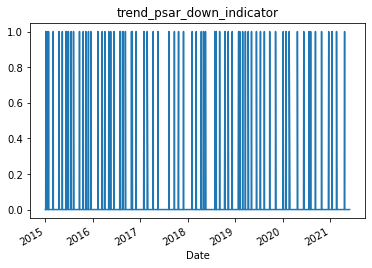

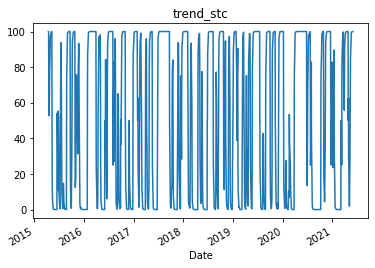

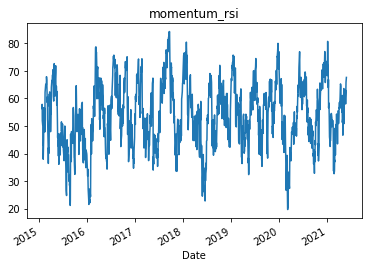

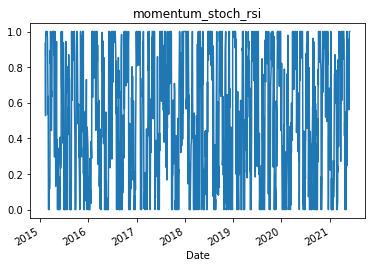

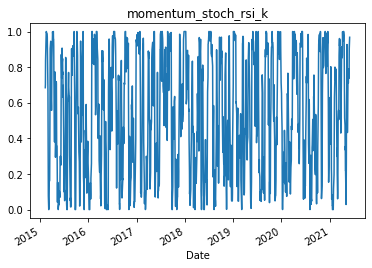

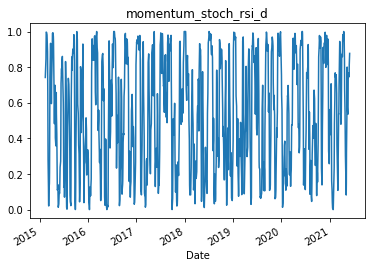

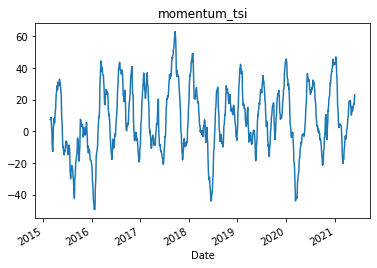

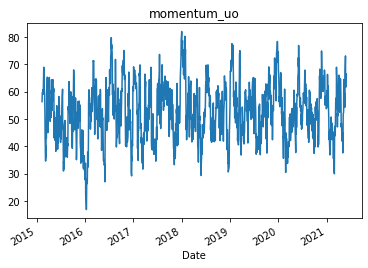

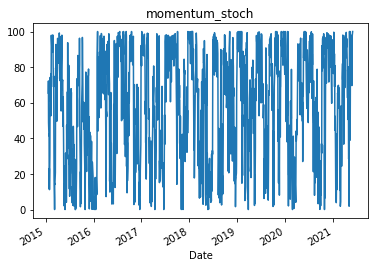

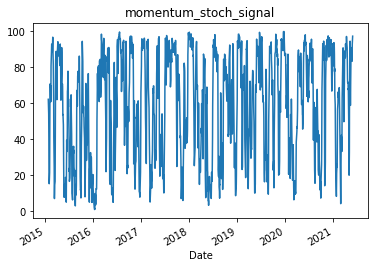

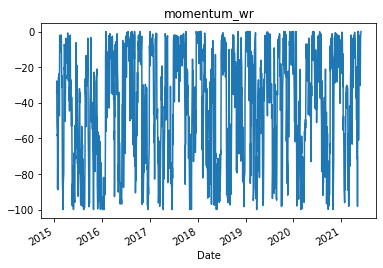

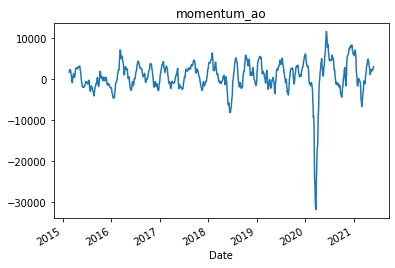

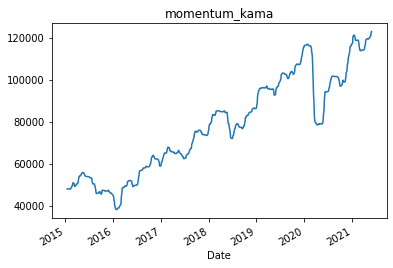

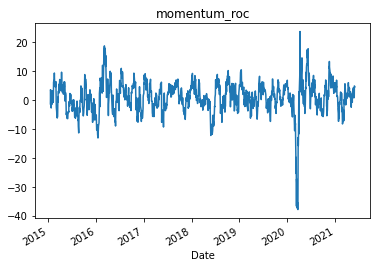

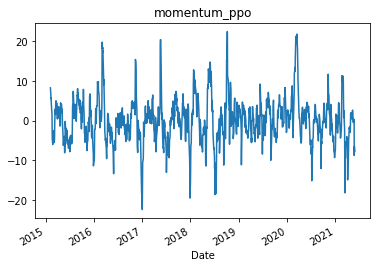

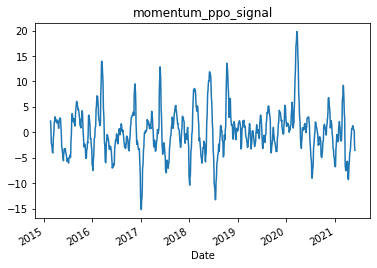

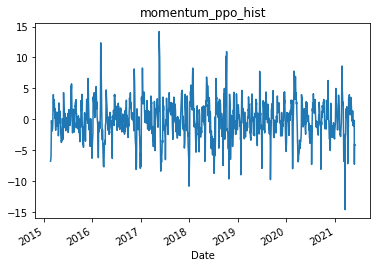

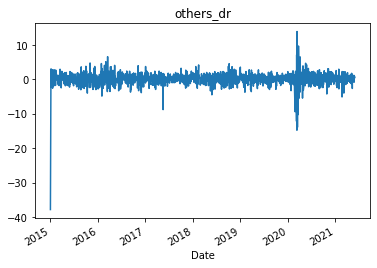

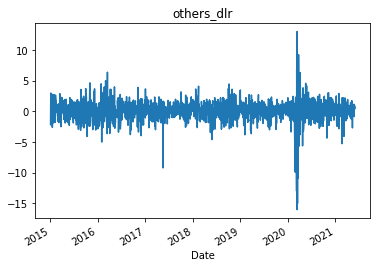

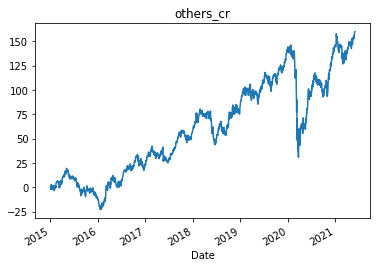

In [ ]:
# df_ta['trend_psar_up'].plot()

for col_ in df_ta.columns[6:]:
#     df_ta['Open'].plot(alpha=0.05, marker='o')
    df_ta[col_].plot()
    plt.title(col_)
    plt.show()


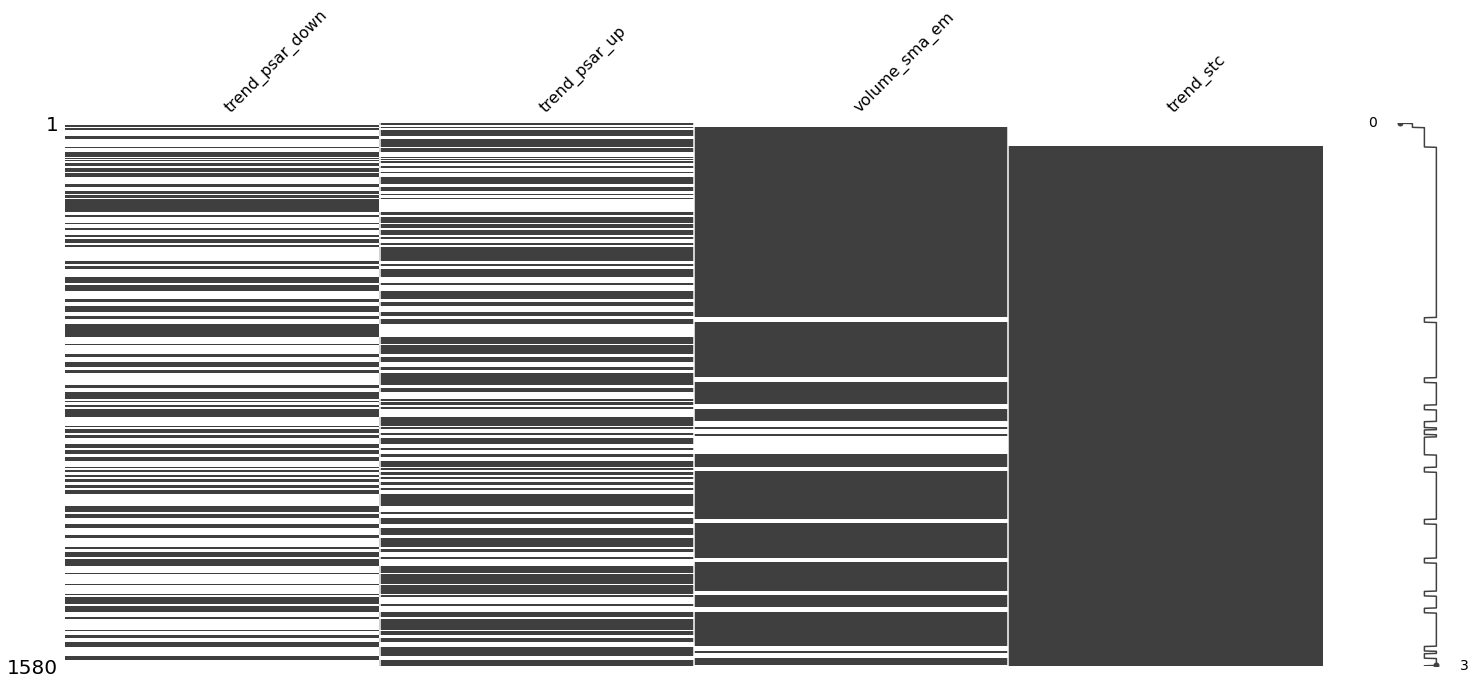

In [ ]:
missingno.matrix(df_ta[['trend_psar_down','trend_psar_up','volume_sma_em','trend_stc']]);

In [ ]:
df_ta_filled = add_all_ta_features(
    df_bovespa, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

C:\Users\fabio\Anaconda\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\fabio\Anaconda\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [ ]:
df_ta_filled.corr().style.background_gradient(cmap='viridis')

In [ ]:
days = {'Monday':0,'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

df_ta_filled['week_day'] = df_ta_filled.index.day_name().map(days)

In [ ]:
(100*(abs(df_ta_filled.corr())>0.85).sum(axis=0)/df_ta_filled.shape[1]).to_frame().T

Open       High        Low      Close  Adj Close    Volume  \
0  34.444444  34.444444  34.444444  34.444444  34.444444  1.111111   

   volume_adi  volume_obv  volume_cmf  volume_fi  volume_mfi  volume_em  \
0   35.555556   34.444444    1.111111   1.111111    2.222222   1.111111   

   volume_sma_em  volume_vpt  volume_nvi  volume_vwap  volatility_atr  \
0       1.111111    1.111111    2.222222    34.444444        1.111111   

   volatility_bbm  volatility_bbh  volatility_bbl  volatility_bbw  \
0       34.444444       34.444444       34.444444        2.222222   

   volatility_bbp  volatility_bbhi  volatility_bbli  volatility_kcc  \
0        8.888889         1.111111         1.111111       34.444444   

   volatility_kch  volatility_kcl  volatility_kcw  volatility_kcp  \
0       34.444444       34.444444        2.222222        6.666667   

   volatility_kchi  volatility_kcli  volatility_dcl  volatility_dch  \
0         1.111111         1.111111       34.444444       34.444444   

   volatility_dcm  volatility_dcw  volatility_dcp  volatility_ui  trend_macd  \
0       34.444444        3.333333        8.888889       4.444444    4.444444   

   trend_macd_signal  trend_macd_diff  trend_sma_fast  trend_sma_slow  \
0           4.444444         1.111111       34.444444       34.444444   

   trend_ema_fast  trend_ema_slow  trend_adx  trend_adx_pos  trend_adx_neg  \
0       34.444444       34.444444   1.111111       1.111111       1.111111   

   trend_vortex_ind_pos  trend_vortex_ind_neg  trend_vortex_ind_diff  \
0              2.222222              2.222222               6.666667   

   trend_trix  trend_mass_index  trend_cci  trend_dpo  trend_kst  \
0    1.111111          1.111111   8.888889   1.111111   3.333333   

   trend_kst_sig  trend_kst_diff  trend_ichimoku_conv  trend_ichimoku_base  \
0       2.222222        1.111111            34.444444            34.444444   

   trend_ichimoku_a  trend_ichimoku_b  trend_visual_ichimoku_a  \
0         34.444444         34.444444                34.444444   

   trend_visual_ichimoku_b  trend_aroon_up  trend_aroon_down  trend_aroon_ind  \
0                34.444444        2.222222          2.222222         3.333333   

   trend_psar_up  trend_psar_down  trend_psar_up_indicator  \
0      34.444444        34.444444                 1.111111   

   trend_psar_down_indicator  trend_stc  momentum_rsi  momentum_stoch_rsi  \
0                   1.111111   1.111111      5.555556            2.222222   

   momentum_stoch_rsi_k  momentum_stoch_rsi_d  momentum_tsi  momentum_uo  \
0              3.333333              2.222222      2.222222     1.111111   

   momentum_stoch  momentum_stoch_signal  momentum_wr  momentum_ao  \
0        7.777778               7.777778     7.777778     4.444444   

   momentum_kama  momentum_roc  momentum_ppo  momentum_ppo_signal  \
0      34.444444      1.111111      2.222222             2.222222   

   momentum_ppo_hist  others_dr  others_dlr  others_cr  week_day  
0           1.111111   2.222222    2.222222  34.444444  1.111111

In [ ]:
# column = 'Open'
# plt.figure(figsize=(10,20))
# df_ta_filled.corr()[column].sort_values(ascending=True).plot(kind='barh')
# plt.tight_layout()

In [ ]:
# EDA.print_correlation_matrix(df_ta_filled,annot=False)

In [ ]:
def target_High_maior_Open(row, delta):
    
    if row['High'] > (1+delta)*row['Open']:
        target = 1
    else:
        target = 0
    
    return target

df_ta_filled['target_futuro'] = df_ta_filled.apply(target_High_maior_Open, delta=0.01,axis=1)

In [ ]:
# No dia seguinte, eu tive uma valorização de 1%?

df_ta_filled['target'] = df_ta_filled['target_futuro'].shift(-1)

df_ta_filled.dropna(inplace=True)

In [ ]:
df_ta_filled.head(3)

Open     High      Low    Close  Adj Close   Volume  \
Date                                                                 
2015-01-02  50005.0  50005.0  48345.0  48512.0    48512.0  2882100   
2015-01-05  48512.0  48512.0  47264.0  47517.0    47517.0  3866100   
2015-01-06  47517.0  48061.0  47338.0  48001.0    48001.0  4559300   

              volume_adi  volume_obv  volume_cmf     volume_fi  volume_mfi  \
Date                                                                         
2015-01-02 -2.302208e+06     2882100   -0.798795  0.000000e+00   50.000000   
2015-01-05 -4.600802e+06     -984000   -0.681782 -3.846770e+09    0.000000   
2015-01-06 -7.982326e+05     3575300   -0.070593 -2.981988e+09   54.132285   

               volume_em  volume_sma_em    volume_vpt  volume_nvi  \
Date                                                                
2015-01-02  0.000000e+00   0.000000e+00 -1.087748e+06      1000.0   
2015-01-05 -4.154512e+07  -4.154512e+07 -1.170019e+06      1000.0   
2015-01-06 -2.989176e+06  -2.226715e+07 -3.285497e+04      1000.0   

             volume_vwap  volatility_atr  volatility_bbm  volatility_bbh  \
Date                                                                       
2015-01-02  48954.000000             0.0         48512.0    48512.000000   
2015-01-05  48272.430055             0.0         48014.5    49009.500000   
2015-01-06  48081.941411             0.0         48010.0    48822.513795   

            volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
Date                                                                          
2015-01-02    48512.000000        0.000000        0.000000              0.0   
2015-01-05    47019.500000        4.144581        0.250000              0.0   
2015-01-06    47197.486205        3.384769        0.494462              0.0   

            volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
Date                                                                          
2015-01-02              0.0    48954.000000    50614.000000    47294.000000   
2015-01-05              0.0    48359.166667    49813.166667    46905.166667   
2015-01-06              0.0    48172.777778    49383.111111    46962.444444   

            volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
Date                                                                           
2015-01-02        6.781877        0.366867              0.0              0.0   
2015-01-05        6.013338        0.210397              0.0              0.0   
2015-01-06        5.024968        0.429037              0.0              0.0   

            volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
Date                                                                         
2015-01-02         48345.0         50005.0         49175.0        3.421834   
2015-01-05         47264.0         50005.0         48634.5        5.708692   
2015-01-06         47264.0         50005.0         48634.5        5.709227   

            volatility_dcp  volatility_ui  trend_macd  trend_macd_signal  \
Date                                                                       
2015-01-02        0.100602            0.0    0.000000           0.000000   
2015-01-05        0.092302            0.0  -79.373219         -15.874644   
2015-01-06        0.268880            0.0 -102.045990         -33.108913   

            trend_macd_diff  trend_sma_fast  trend_sma_slow  trend_ema_fast  \
Date                                                                          
2015-01-02         0.000000         48512.0         48512.0    48512.000000   
2015-01-05       -63.498575         48014.5         48014.5    48358.923077   
2015-01-06       -68.937077         48010.0         48010.0    48303.857988   

            trend_ema_slow  trend_adx  trend_adx_pos  trend_adx_neg  \
Date                                                                  
2015-01-02    48512.000000        0.0      

In [ ]:
df_ta_filled['target'].value_counts()/df_ta_filled['target'].value_counts().sum()

0.0    0.595313
1.0    0.404687
Name: target, dtype: float64

In [ ]:
# Avaliando a Target em relação as variáveis explicativas

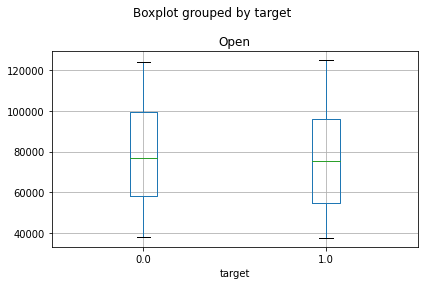

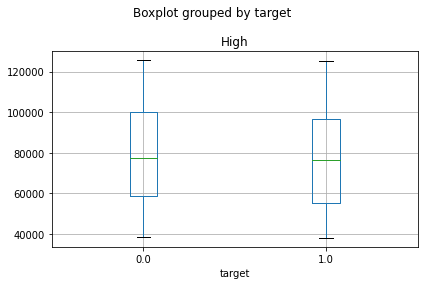

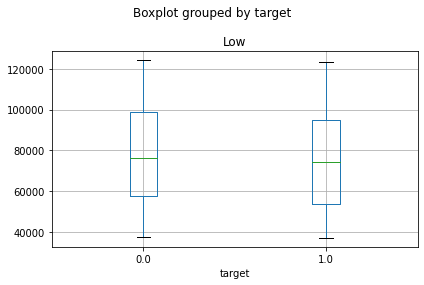

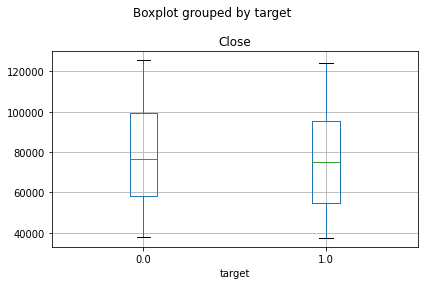

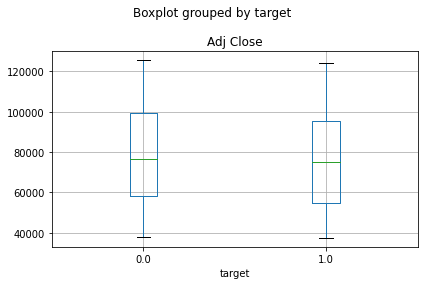

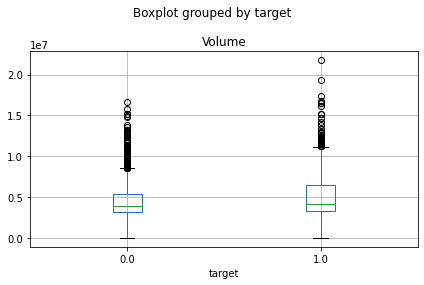

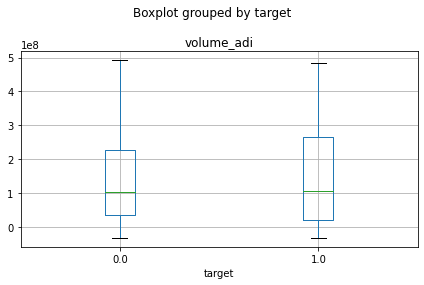

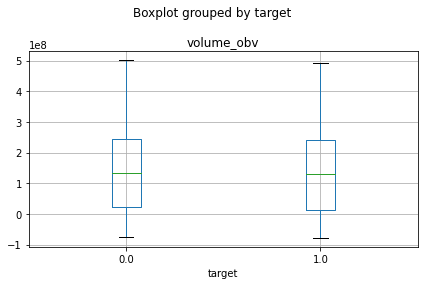

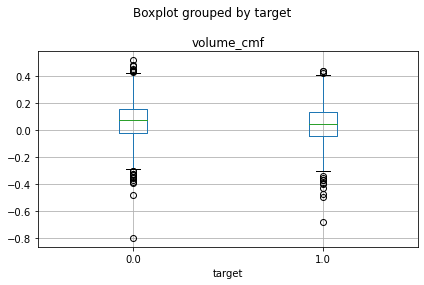

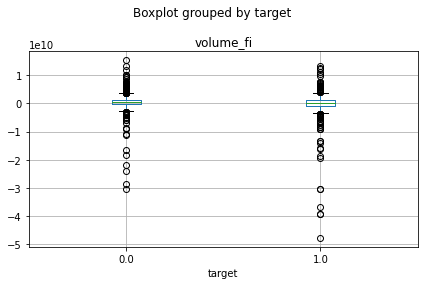

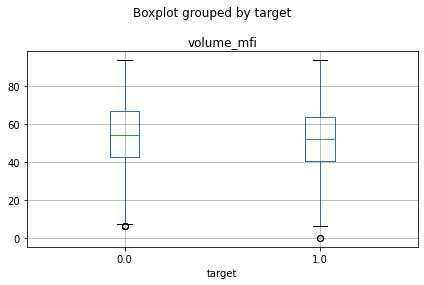

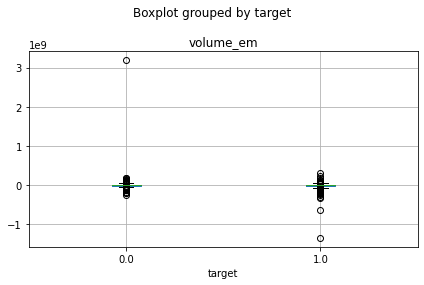

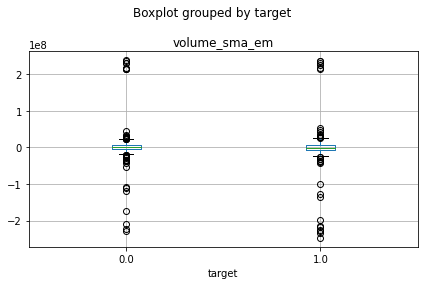

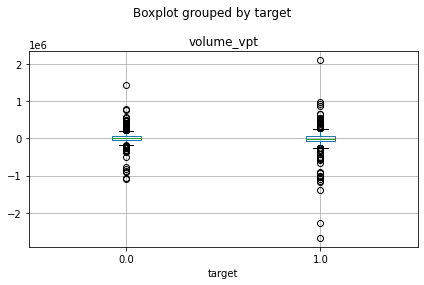

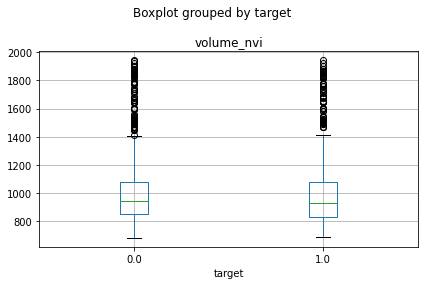

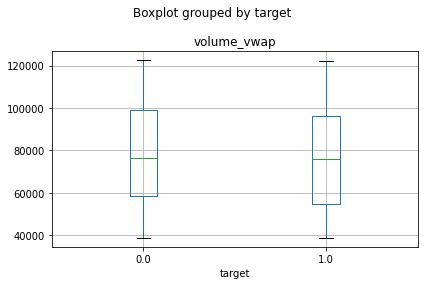

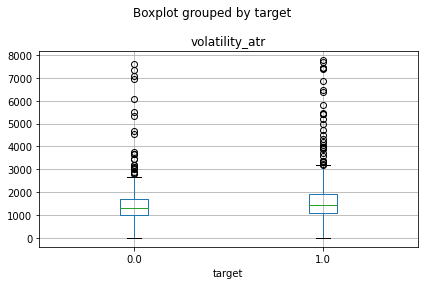

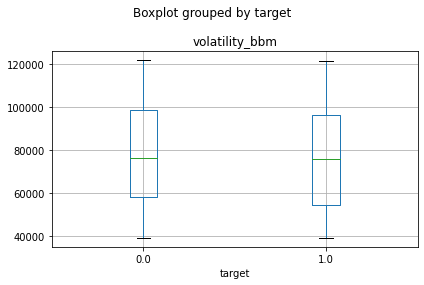

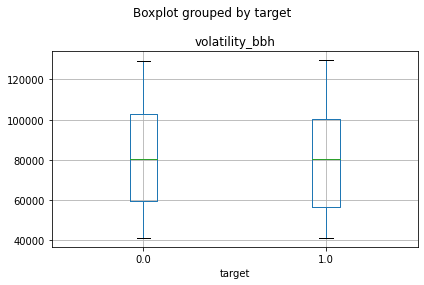

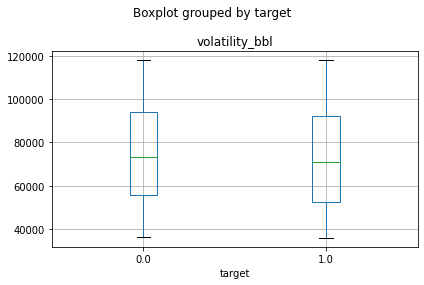

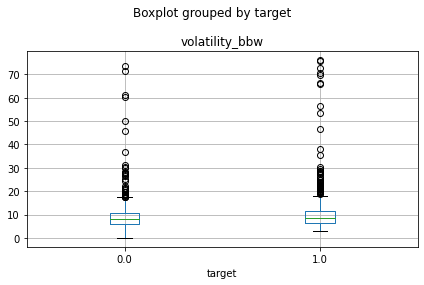

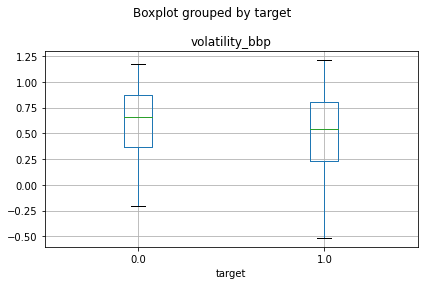

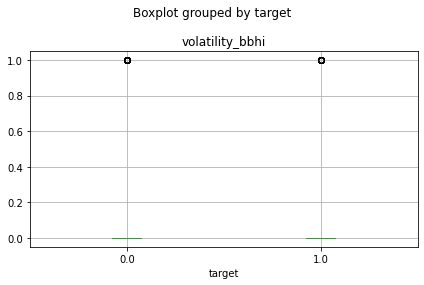

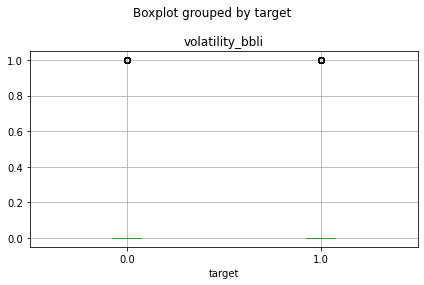

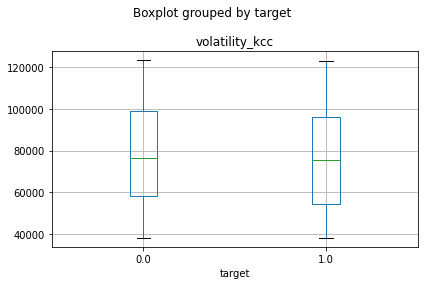

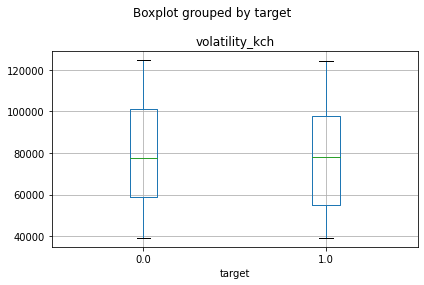

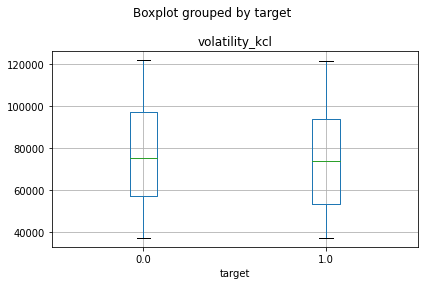

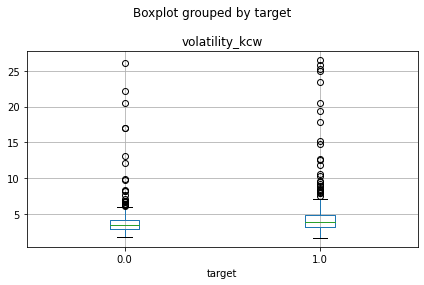

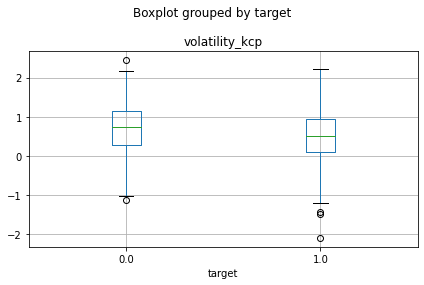

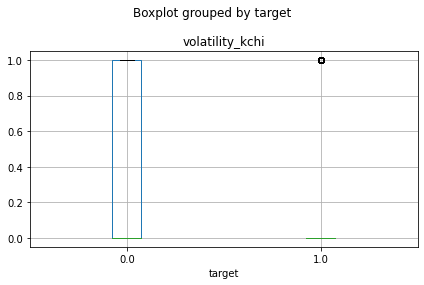

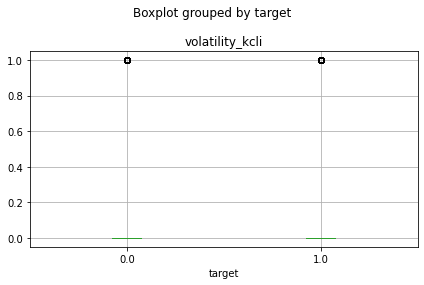

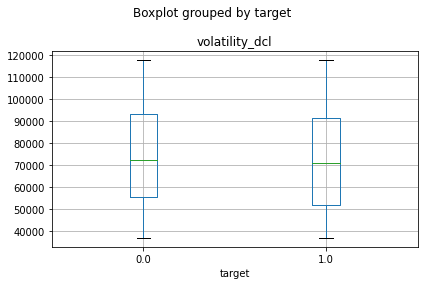

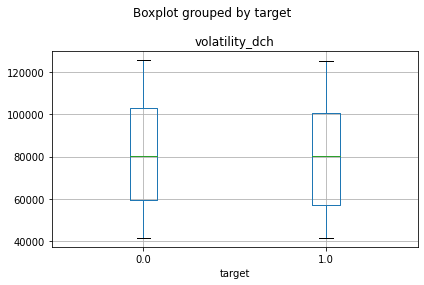

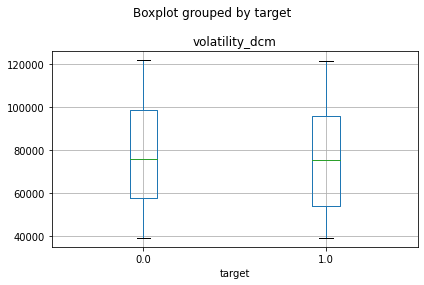

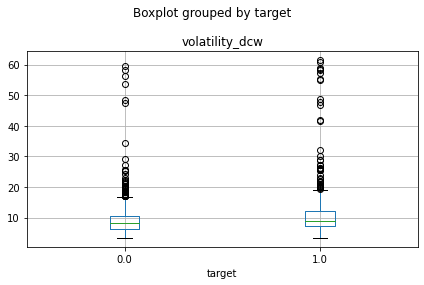

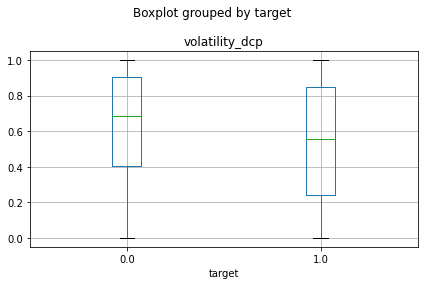

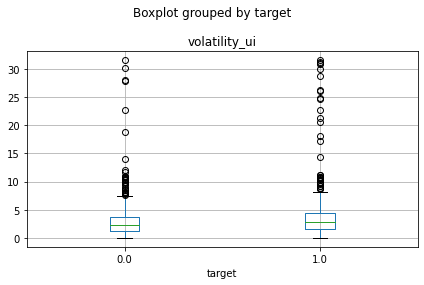

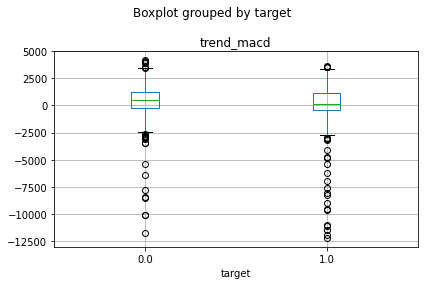

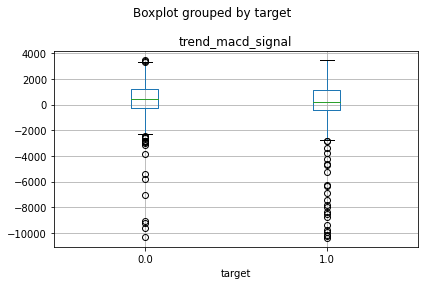

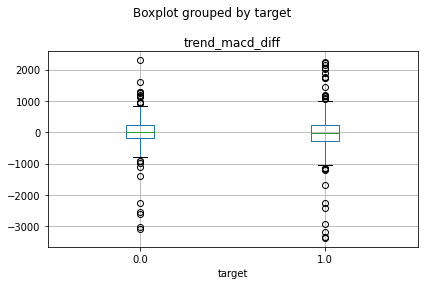

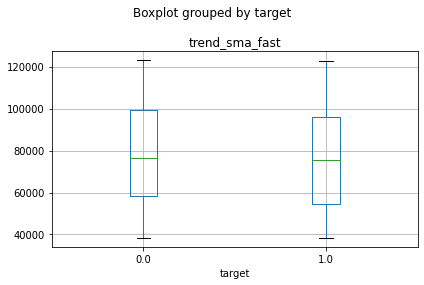

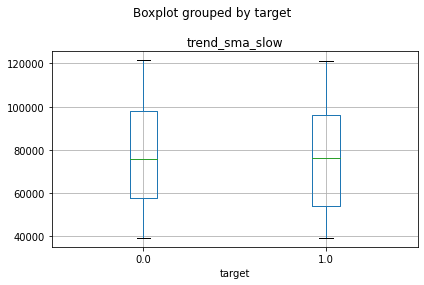

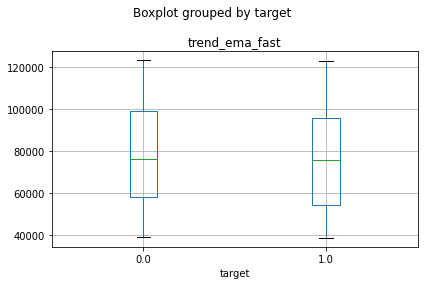

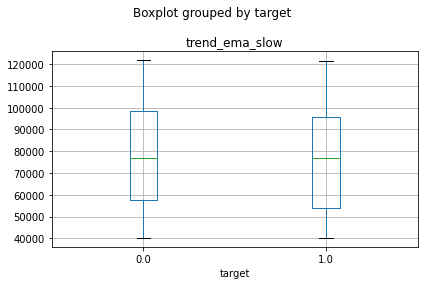

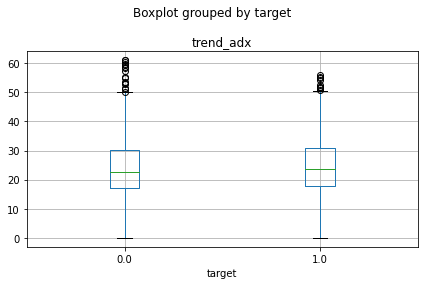

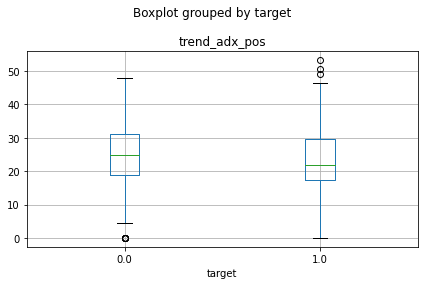

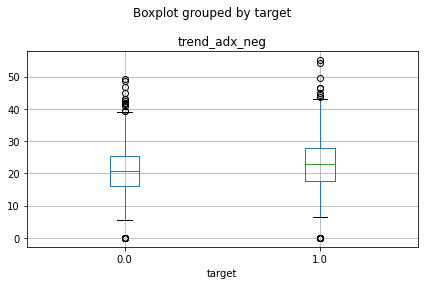

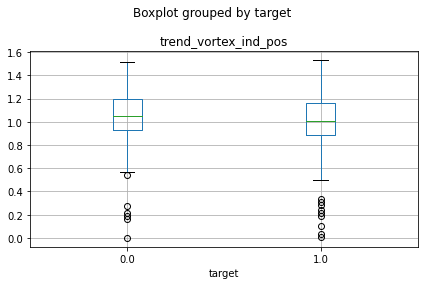

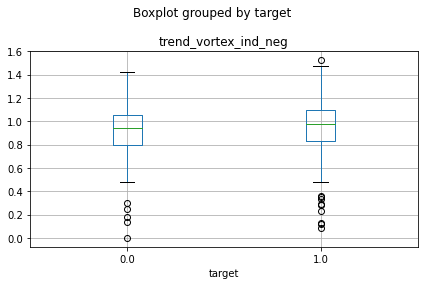

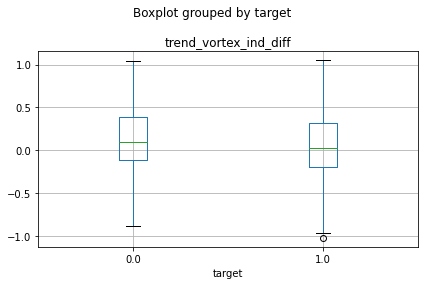

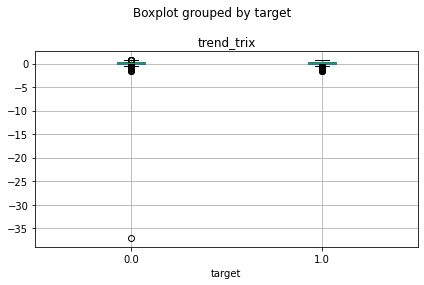

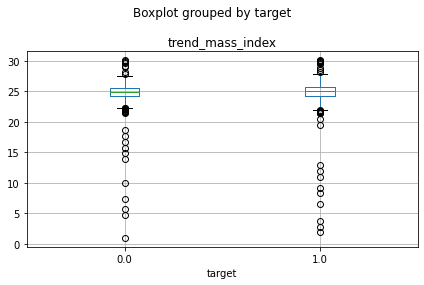

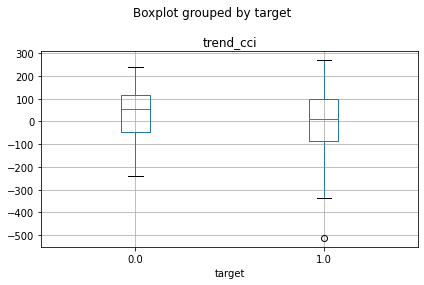

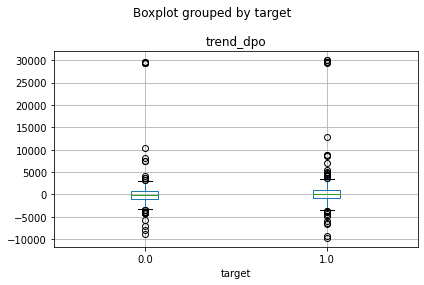

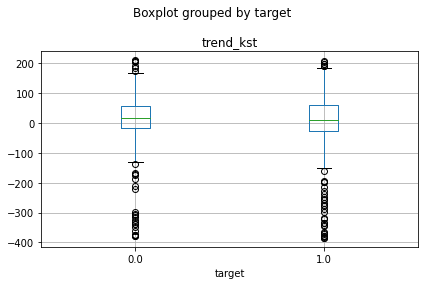

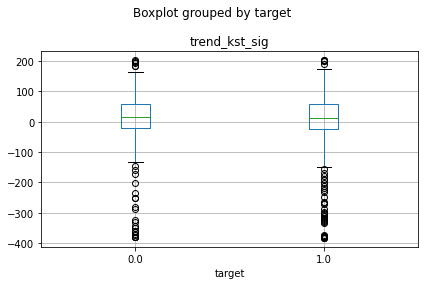

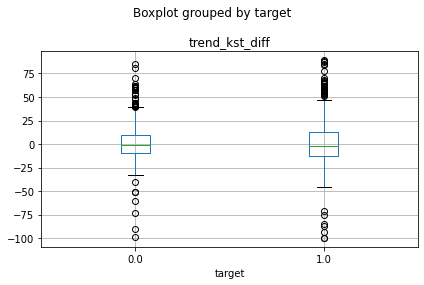

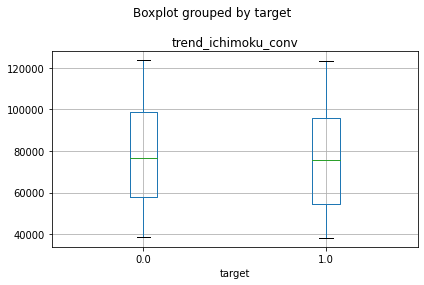

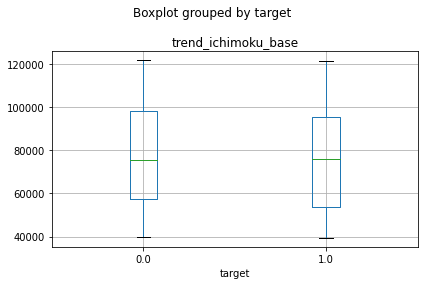

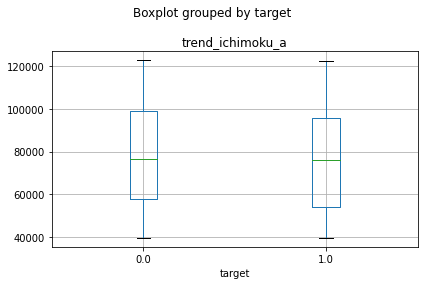

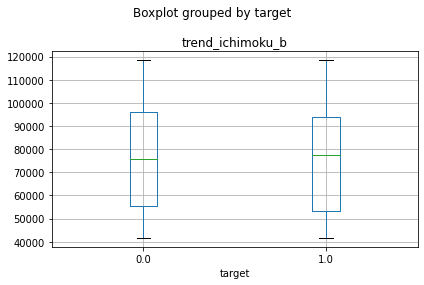

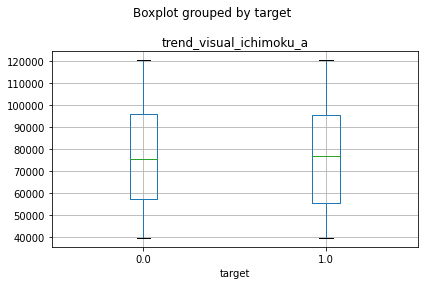

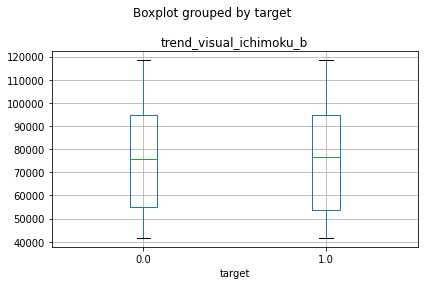

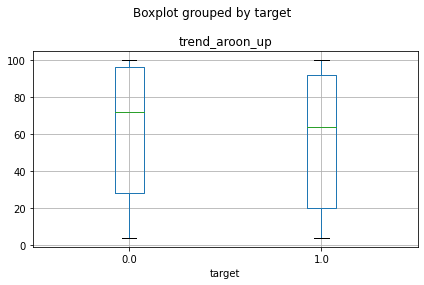

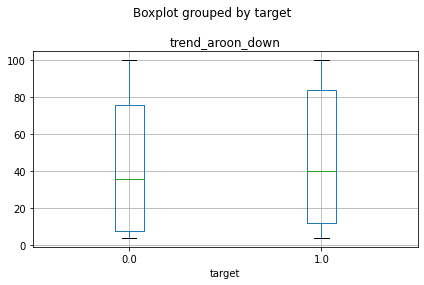

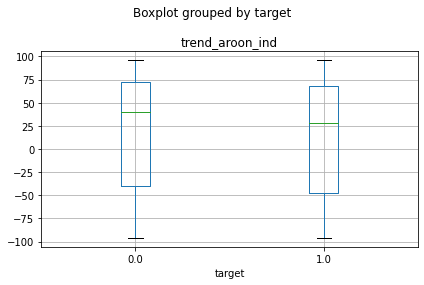

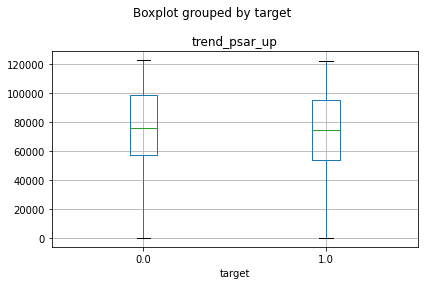

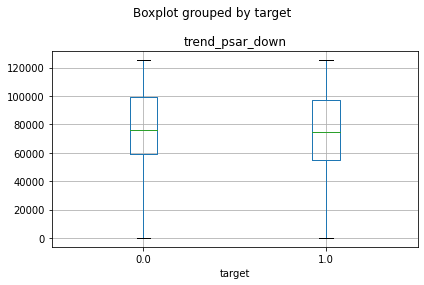

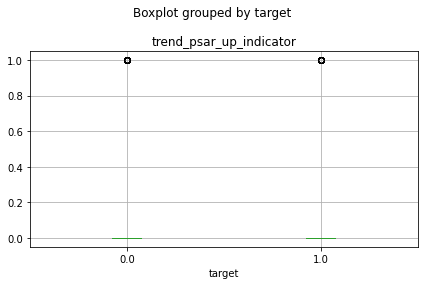

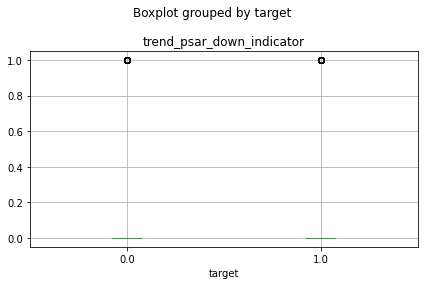

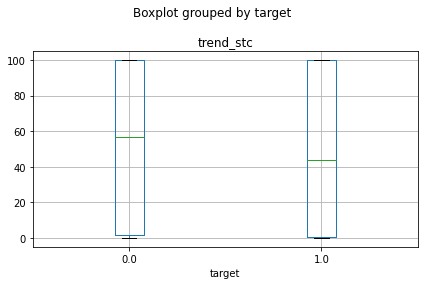

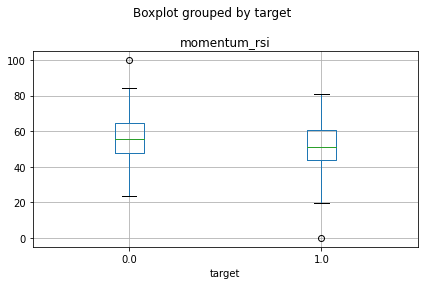

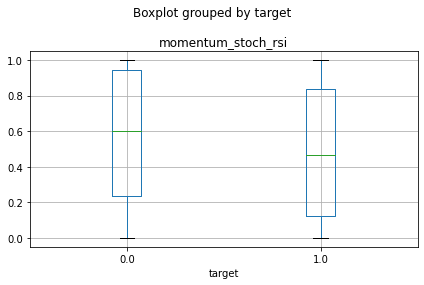

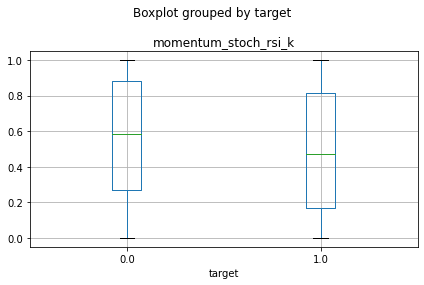

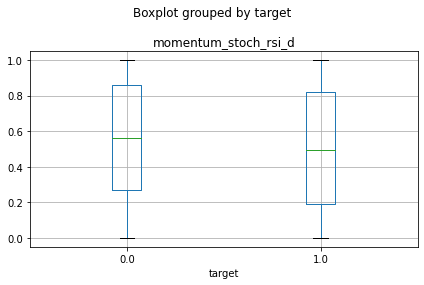

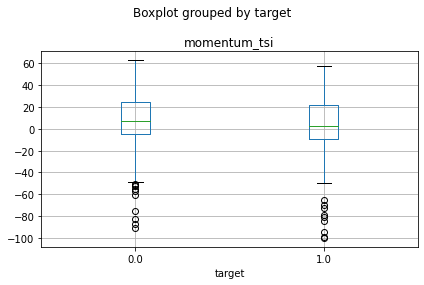

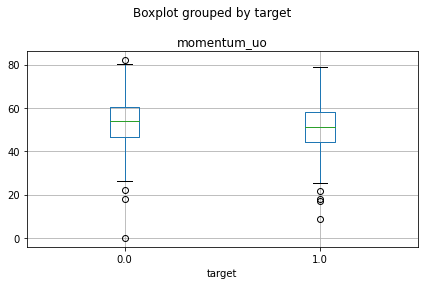

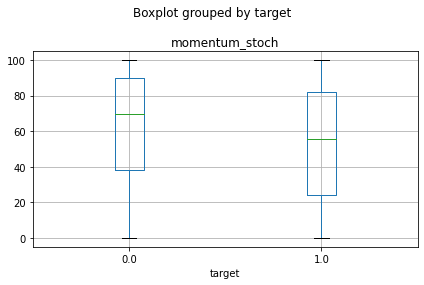

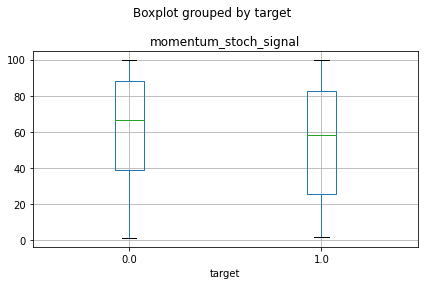

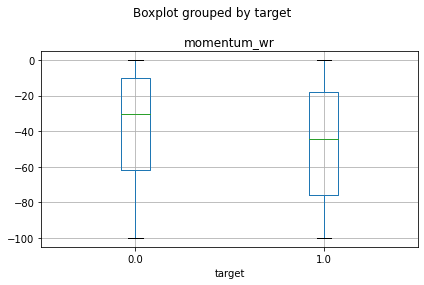

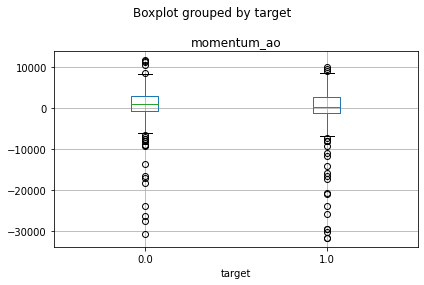

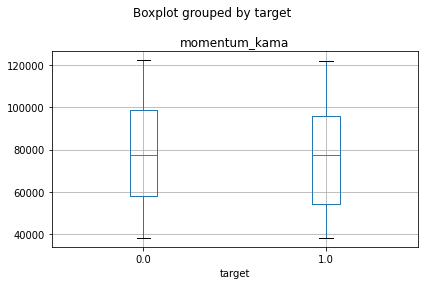

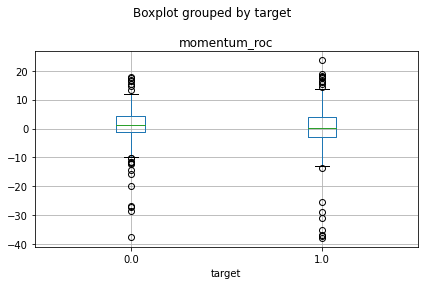

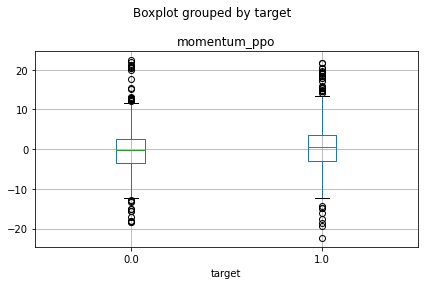

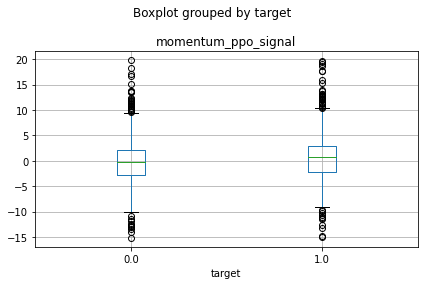

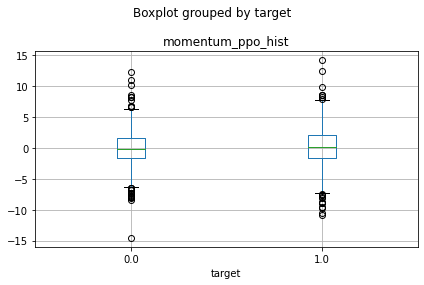

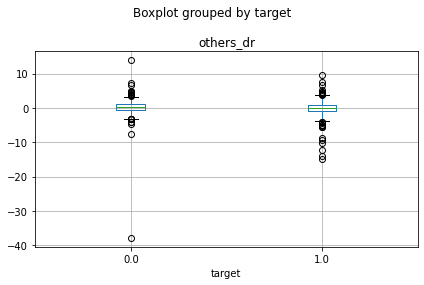

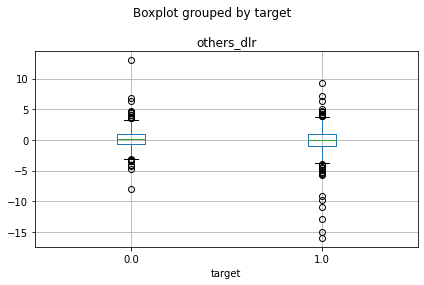

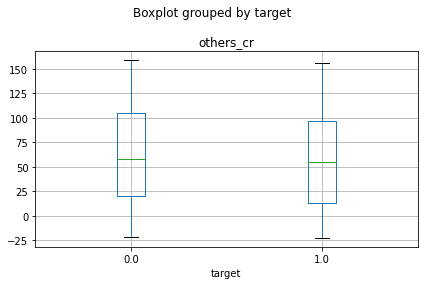

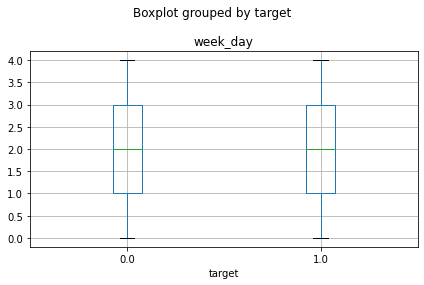

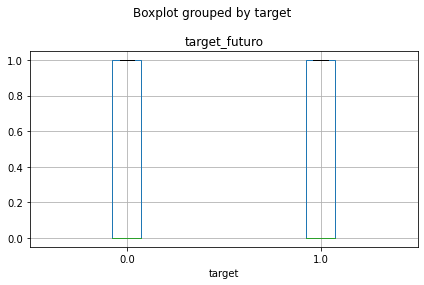

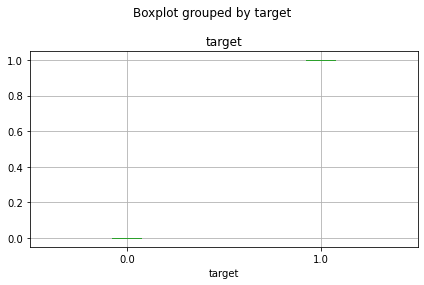

In [ ]:
for cols_ in df_ta_filled.columns.to_list():
    df_ta_filled.boxplot(column=cols_,by='target')
    plt.tight_layout()
    plt.show()

In [ ]:
# adicionando 3 colunas random

df_ta_filled['randNumCol1'] = np.random.randint(1, 100, df_ta_filled.shape[0])
df_ta_filled['randNumCol2'] = np.random.randint(1, 100, df_ta_filled.shape[0])
df_ta_filled['randNumCol3'] = np.random.randint(1, 100, df_ta_filled.shape[0])

In [ ]:
df_ta_filled['delta_max_intra_day'] = df_ta_filled.apply(lambda row:row['High']/row['Open']-1, axis=1)

<AxesSubplot:>

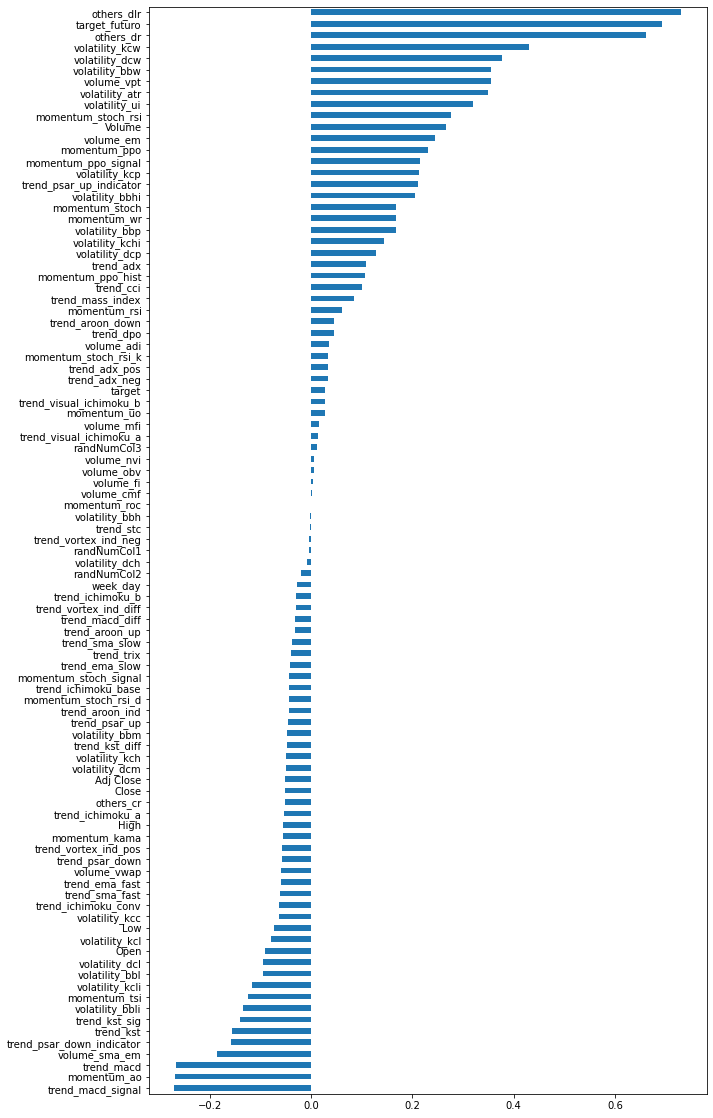

In [ ]:
plt.figure(figsize=(10,20))
df_ta_filled.corr()['delta_max_intra_day'].sort_values()[:-1].plot(kind='barh')

In [ ]:
# plt.figure(figsize=(10,20))
# df_ta_filled.corr()['target'].sort_values()[:-1].plot(kind='barh')

In [ ]:
# df_ta_filled.filter(like='trend').columns

In [ ]:
df_model = df_ta_filled.copy()
df_model = df_model[df_model.index.year.isin([2019,2018])]

In [ ]:
(df_model['target'].value_counts()/df_model.shape[0]).to_frame()

target
0.0  0.629328
1.0  0.370672

In [ ]:
# from fastai.structured import  add_datepart

# add_datepart(df_model, 'Date')

In [ ]:
# Referencias
# https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
# https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001
# https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

In [ ]:
# Resumo: # https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

# use a technique known as recursive forecasting.

In [ ]:
df_model.head()

Open     High      Low    Close  Adj Close   Volume  \
Date                                                                 
2018-01-02  76403.0  77909.0  76403.0  77891.0    77891.0  2880300   
2018-01-03  77889.0  78414.0  77602.0  77995.0    77995.0  3142200   
2018-01-04  77998.0  79135.0  77998.0  78647.0    78647.0  3486100   
2018-01-05  78644.0  79071.0  78218.0  79071.0    79071.0  2747100   
2018-01-08  79070.0  79395.0  78631.0  79379.0    79379.0  2550800   

              volume_adi  volume_obv  volume_cmf     volume_fi  volume_mfi  \
Date                                                                         
2018-01-02  8.769148e+07   133738500    0.193751  1.128140e+09   84.373852   
2018-01-03  8.759087e+07   136880700    0.185353  1.013661e+09   84.538482   
2018-01-04  8.808450e+07   140366800    0.232177  1.193558e+09   84.217389   
2018-01-05  9.083160e+07   143113900    0.238459  1.189445e+09   93.545884   
2018-01-08  9.327556e+07   145664700    0.275704  1.131760e+09   93.194900   

               volume_em  volume_sma_em    volume_vpt  volume_nvi  \
Date                                                                
2018-01-02  4.700531e+07   1.530645e+07  56134.220308  903.857434   
2018-01-03  2.201719e+07   1.764796e+07  60329.683199  903.857434   
2018-01-04  1.821561e+07   1.627522e+07  33337.551486  903.857434   
2018-01-05  2.421972e+06   1.886242e+07  43952.194512  908.730290   
2018-01-08  1.103709e+07   1.940809e+07  24746.067268  912.270007   

             volume_vwap  volatility_atr  volatility_bbm  volatility_bbh  \
Date                                                                       
2018-01-02  73976.652104     1016.489595        74031.30    77313.368561   
2018-01-03  74386.871097      996.040636        74276.55    77950.288993   
2018-01-04  74923.579296     1010.436572        74581.60    78624.537318   
2018-01-05  75473.174821      994.692915        74871.75    79309.590415   
2018-01-08  76154.683060      971.623623        75216.35    79922.206448   

            volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
Date                                                                          
2018-01-02    70749.231439        8.866705        1.087998              1.0   
2018-01-03    70602.811007        9.892056        1.006085              1.0   
2018-01-04    70538.662682       10.841648        1.002778              1.0   
2018-01-05    70433.909585       11.854512        0.973119              0.0   
2018-01-08    70510.493552       12.512855        0.942284              0.0   

            volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
Date                                                                          
2018-01-02              0.0    75000.233333    75862.133333    74138.333333   
2018-01-03              0.0    75492.100000    76345.400000    74638.800000   
2018-01-04              0.0    76079.233333    76967.033333    75191.433333   
2018-01-05              0.0    76639.933333    77531.833333    75748.033333   
2018-01-08              0.0    77102.400000    77883.900000    76320.900000   

            volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
Date                                                                           
2018-01-02        2.298393        2.176973              1.0              0.0   
2018-01-03        2.260634        1.966600              1.0              0.0   
2018-01-04        2.333883        1.946140              1.0              0.0   
2018-01-05        2.327507        1.862858              1.0              0.0   
2018-01-08        2.027174        1.956558              1.0              0.0   

            volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
Date                                                                         
2018-01-02         71356.0         77909.0         74632.5        8.851661   
2018-01-03         71356.0         78414.0         74885.

In [ ]:
# X_train.columns

In [ ]:
to_drop = list(df_ta_filled.filter(like='target').columns)

to_drop = to_drop + ['Open', 'High', 'Low', 'Close', 'Adj Close'] + ['delta_max_intra_day']

X_train, X_test, y_train, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
                                        df_model.drop(columns=to_drop),
                                        df_model['target'],
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)

# X_val, X_test, y_val, y_test= train_test_split(
# #                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
#                                         X_test,
#                                         y_test,
#                                         test_size=0.5,
#                                         random_state=42,
#                                         shuffle=False)



print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
# print('X_val shape:{}'.format(X_val.shape))
# print('y_val shape:{}'.format(y_val.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))


X_train shape:(392, 88)
y_train shape:(392,)
X_test shape:(99, 88)
y_test shape:(99,)

Treino : periodo de 2018-01-02 00:00:00 ate 2019-08-07 00:00:00

Teste : periodo de 2019-08-08 00:00:00 ate 2019-12-30 00:00:00


X_train shape:(392, 88)
y_train shape:(392,)
X_val shape:(49, 88)
y_val shape:(49,)
X_test shape:(50, 88)
y_test shape:(50,)

Treino : periodo de 2018-01-02 00:00:00 ate 2019-08-07 00:00:00

Validação : periodo de 2019-08-08 00:00:00 ate 2019-10-15 00:00:00

Teste : periodo de 2019-10-16 00:00:00 ate 2019-12-30 00:00:00


<AxesSubplot:xlabel='Date'>

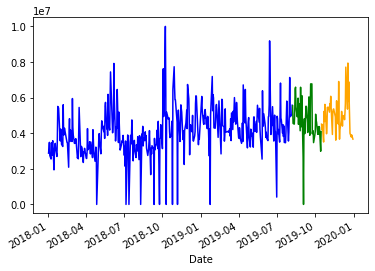

In [ ]:
to_drop = list(df_ta_filled.filter(like='target').columns)

to_drop = to_drop + ['Open', 'High', 'Low', 'Close', 'Adj Close'] + ['delta_max_intra_day']

X_train, X_test, y_train, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
                                        df_model.drop(columns=to_drop),
                                        df_model['target'],
                                        test_size=0.2,
                                        random_state=42,
                                        shuffle=False)

X_val, X_test, y_val, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
                                        X_test,
                                        y_test,
                                        test_size=0.5,
                                        random_state=42,
                                        shuffle=False)



print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_val shape:{}'.format(X_val.shape))
print('y_val shape:{}'.format(y_val.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))


print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
print('\nValidação : periodo de {} ate {}'.format(X_val.index.min(), X_val.index.max()))
print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

X_train['Volume'].plot(c='blue')
X_val['Volume'].plot(c='green')
X_test['Volume'].plot(c='orange')

<AxesSubplot:xlabel='week_day'>

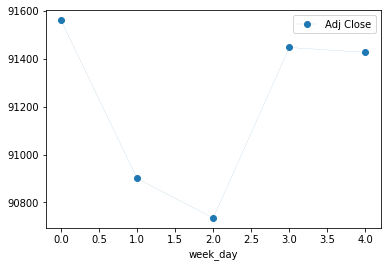

In [ ]:
df_model[['Adj Close', 'week_day']].groupby(['week_day']).mean().plot(marker='o', lw=0.1)

In [ ]:
df_aux = df_model.copy()
df_aux = df_aux[['Adj Close']]

for i in range(0,15):
    df_aux['Adj Close_'+str(i)]=df_aux['Adj Close'].shift(i)
    
df_aux.corr().style.background_gradient(cmap='viridis')

In [ ]:
min(df_model.index)

Timestamp('2018-01-02 00:00:00')

In [ ]:
max(df_model.index)

Timestamp('2019-12-30 00:00:00')

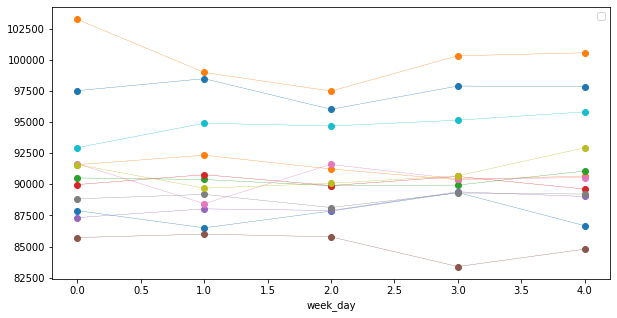

In [ ]:
aux = df_model.copy()
aux['month'] = df_model.index.month
aux_ = aux[['Adj Close','month', 'week_day']].groupby(['week_day','month']).mean().reset_index() 
fig, ax = plt.subplots(1,1,figsize=(10,5))
from sklearn.preprocessing import MinMaxScaler


for months in range(1,13):
    scaler = MinMaxScaler()
    aux_2 = aux_.query('month==@months')[['Adj Close','week_day']]
#     aux_2['Adj Close'] = (aux_2['Adj Close'] - min(aux_2['Adj Close']))/(max(aux_2['Adj Close']) - min(aux_2['Adj Close']))
    aux_2.plot(x='week_day',y='Adj Close',marker='o', lw=0.3,ax=ax,label=months)
plt.legend('')
#     aux_2.plot(x='week_day',y='Adj Close',marker='o', lw=0.3,label=months)
#     plt.show()

    
# aux_

# a

In [ ]:
# X_train, X_test, y_train, y_test= train_test_split(
#                                         df_ta_filled[['trend_macd_diff','volume_nvi']],#,'volatility_kcw']],
# #                                         df_ta_filled.drop(columns=to_drop),
#                                         df_ta_filled['target'],
#                                         test_size=0.2,
#                                         random_state=42,
#                                         shuffle=False)


# print('X_train shape:{}'.format(X_train.shape))
# print('y_train shape:{}'.format(y_train.shape))
# print('X_test shape:{}'.format(X_test.shape))
# print('y_test shape:{}'.format(y_test.shape))


# print('\nTreino : periodo de {} ate {}'.format(X_train.index.min(), X_train.index.max()))
# print('\nTeste : periodo de {} ate {}'.format(X_test.index.min(), X_test.index.max()))

In the Last Value method, we will simply set the prediction as the last observed value. In our context, this means we set the current adjusted closing price as the previous day’s adjusted closing price. This is the most cost-effective forecasting model and is commonly used as a benchmark against which more sophisticated models can be compared. There are no hyperparameters to be tuned here.

19

In [ ]:
# Modelo lazy - preve o que aconteceu ontem

y_pred_train_lazy = y_train.shift(1).bfill()
y_pred_val_lazy = y_val.shift(1).bfill()
y_pred_test_lazy = y_test.shift(1).bfill()

# plot_confusion_matrix(classifier, X_train, y_pred_train_lazy, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
# plot_confusion_matrix(classifier, X_test, y_pred_test_lazy, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

from sklearn.metrics import classification_report

print('Treino\n')
print(f'''Perido:{min(y_train.index)} - {max(y_train.index)}, n_meses = {int((max(y_train.index) - min(y_train.index))/np.timedelta64(1, 'M'))}''')
print(classification_report(y_train, y_pred_train_lazy, target_names=['Não Val. %','Valor %']))

print('Validação\n')
print(f'''Perido:{min(y_val.index)} - {max(y_val.index)}, n_meses = {int((max(y_val.index) - min(y_val.index))/np.timedelta64(1, 'M'))}''')
print(classification_report(y_val, y_pred_val_lazy, target_names=['Não Val. %','Valor %']))

print('Teste\n')
print(f'''Perido:{min(y_test.index)} - {max(y_test.index)}, n_meses = {int((max(y_test.index) - min(y_test.index))/np.timedelta64(1, 'M'))}''')
print(classification_report(y_test, y_pred_test_lazy, target_names=['Não Val. %','Valor %']))

Treino

Perido:2018-01-02 00:00:00 - 2019-08-07 00:00:00, n_meses = 19
              precision    recall  f1-score   support

  Não Val. %       0.61      0.61      0.61       239
     Valor %       0.39      0.39      0.39       153

    accuracy                           0.52       392
   macro avg       0.50      0.50      0.50       392
weighted avg       0.52      0.52      0.52       392

Validação

Perido:2019-08-08 00:00:00 - 2019-10-15 00:00:00, n_meses = 2
              precision    recall  f1-score   support

  Não Val. %       0.69      0.69      0.69        32
     Valor %       0.41      0.41      0.41        17

    accuracy                           0.59        49
   macro avg       0.55      0.55      0.55        49
weighted avg       0.59      0.59      0.59        49

Teste

Perido:2019-10-16 00:00:00 - 2019-12-30 00:00:00, n_meses = 2
              precision    recall  f1-score   support

  Não Val. %       0.74      0.76      0.75        38
     Valor %       0.18 

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

# classifier= DecisionTreeClassifier(criterion='entropy',max_depth= 5, min_samples_leaf=0.10)
classifier= LGBMClassifier(max_depth=4, learning_rate=0.01, n_estimators=400, min_child_weight=0.05)

classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

y_pred_proba_train = classifier.predict_proba(X_train)[:,-1]
y_pred_proba_test = classifier.predict_proba(X_test)[:,-1]

print('Treino\n')
print(classification_report(y_train, y_pred_train, target_names=['Não Val. %','Valor %']))

print('Teste\n')
print(classification_report(y_test, y_pred_test, target_names=['Não Val. %','Valor %']))

Treino

              precision    recall  f1-score   support

  Não Val. %       0.93      0.99      0.96       239
     Valor %       0.99      0.88      0.93       153

    accuracy                           0.95       392
   macro avg       0.96      0.94      0.95       392
weighted avg       0.95      0.95      0.95       392

Teste

              precision    recall  f1-score   support

  Não Val. %       0.73      0.94      0.83        70
     Valor %       0.56      0.17      0.26        29

    accuracy                           0.72        99
   macro avg       0.64      0.56      0.54        99
weighted avg       0.68      0.72      0.66        99




### TREINO:###

accuracy:  0.977
precision:  0.9865
recall:  0.9542
f1:  0.9701
log_loss:  0.793
roc_auc:  0.9989

### TESTE:###

accuracy:  0.7071
precision:  0.5
recall:  0.2414
f1:  0.3256
log_loss:  10.1175
roc_auc:  0.6764


train       test
accuracy   0.977041   0.707071
precision  0.986486   0.500000
recall     0.954248   0.241379
f1         0.970100   0.325581
log_loss   0.792986  10.117476
roc_auc    0.998906   0.676355

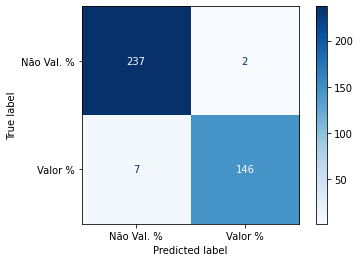

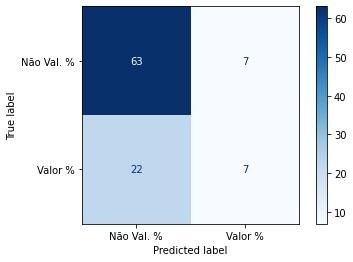

In [ ]:
plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);
plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Não Val. %','Valor %'], cmap =plt.cm.Blues);

results =model_functions.metrics(classifier, 'classification', X_train, X_test, y_train, y_test)
pd.DataFrame(results)

In [ ]:
# PLOTTAR ARVORE

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(classifier, feature_names = X_train.columns, out_file='tree.dot',impurity=True, filled=True)

with open('tree.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

# print(X.columns)

In [ ]:
def plot_feature_imp(model, cols_names, n_features=5):
    fig, axis = plt.subplots(1,1, figsize=(20,15))
    df_feat_imp = (pd.DataFrame({'feature':cols_names, 
                                'importance':model.feature_importances_})
                   .set_index('feature')
                   .sort_values(by='importance', ascending=False)
                   .head(n_features)
                   .sort_values(by='importance', ascending=True)
                   .plot(kind='barh',ax=axis))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    return df_feat_imp
    
feat_imp = plot_feature_imp(classifier, X_train.columns, n_features=50);

In [ ]:
scores = pd.DataFrame({'true':y_train, 'score': y_pred_proba_train})
fig,axes = plt.subplots(1,1, figsize=(10,8))
scores.query('true==1')['score'].plot(kind='hist', bins=15, color='blue', ax=axes, alpha=0.5, label='target_YES')
scores.query('true==0')['score'].plot(kind='hist', bins=15, color='red', ax=axes, alpha= 0.5, label ='target_NO')
plt.legend()

In [ ]:
# REVISAR OS BINS

scores = pd.DataFrame({'true':y_test, 'score': y_pred_proba_test})
fig,axes = plt.subplots(1,1, figsize=(10,8))
scores.query('true==1')['score'].plot(kind='hist', color='blue', ax=axes, alpha=0.5, label='target_YES')
scores.query('true==0')['score'].plot(kind='hist', color='red', ax=axes, alpha= 0.5, label ='target_NO')
plt.legend()

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from lightgbm import LGBMClassifier
from time import time

def hyperopt(param_space, X_train, y_train, num_eval):
  start = time()

  def objective_function(params):
    clf = LGBMClassifier(n_jobs=3, **params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return {'loss': -score, 'status':STATUS_OK}

  trials = Trials()
  best_param = fmin(objective_function,
                    param_space,
                    algo=tpe.suggest,
                    max_evals=num_eval,
                    rstate=np.random.RandomState(1),
                    verbose=True)
  loss = [x['result']['loss'] for x in trials.trials]

  return trials, best_param

param_hyperopt = {
    'learning_rate':hp.loguniform('learning_rate',np.log(0.001),np.log(1)),
    'max_depth':scope.int(hp.quniform('max_depth',5,15,1)),
    'n_estimators':scope.int(hp.quniform('n_estimators',5,35,1)),
    'num_leaves': scope.int(hp.quniform('num_leaves',5,50,1)),
    'boosting_type':hp.choice('boosting_type',['gbdt','dart']),
    'colsample_bytree':hp.uniform('colsample_by_tree',0.6,1.0),
    'reg_lambda':hp.uniform('reg_lambda',0.0,1.0)
}

results_hyperopt, best_param = hyperopt(param_hyperopt, X_train, y_train, num_eval=1000)

print(best_param)
best_param